### Команда "Страховщики":

- Мартынов Дмитрий
- Осипов Роман
- Иванков Дмитрий
- Плахотин Андрей
- Максим Макаров
- Тайсумова Луиза

# Кейс 10 - Бинарная классификация перекрёстных продаж страхования

- [1. Общая информация о данных](#first)
- [2. Анализ целевой переменной](#second)
- [3. Анализ категориальных признаков](#third)
  - [3.1 Бинарные признаки](#third-one)
  - [3.2 Порядковые признаки](#third-two)
  - [3.3 Высококардинальные категориальные признаки](#third-three)
- [4. Анализ числовых признаков](#fource)
- [5. Корреляционный анализ по числовым признакам](#fifth)
- [6. Итоги EDA и рекомендации](#sixth)
- [7. Baseline - логистическая регрессия](#seventh)

__________________________

# Метод Опорных векторов (SVM)

### Подготавливаем данные и производим импорт библиотек

In [1]:
# ==================== ИМПОРТ БИБЛИОТЕК ====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import gc
import warnings
from tqdm.notebook import tqdm

# Импорт scikit-learn компонентов
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    RandomizedSearchCV,
    GridSearchCV
)
from sklearn.svm import SVC, LinearSVC

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import (
    classification_report, 
    roc_auc_score, 
    precision_recall_fscore_support,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    average_precision_score
)

# Для ускоренных методов
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

# Категориальные энкодеры
from category_encoders import CountEncoder

# Настройки предупреждений
warnings.filterwarnings('ignore')

# Настройки для визуализации
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

# Настройки Pandas для отображения
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.4f}'.format)

print(" Библиотеки загружены и настроены для работы с большими данными")
print(f" Pandas версия: {pd.__version__}")
print(f" NumPy версия: {np.__version__}")

 Библиотеки загружены и настроены для работы с большими данными
 Pandas версия: 2.3.3
 NumPy версия: 2.3.3


### Производим предварительную обработку

In [2]:
FILE_PATH = 'https://media.githubusercontent.com/media/taysumova/urfu_ml/refs/heads/main/data_sources/train.csv'

df = pd.read_csv(FILE_PATH, index_col='id')

df_sample = df.sample(n=1_500_000, random_state=42)
X = df_sample.drop("Response", axis=1)
y = df_sample["Response"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=1_000_000,
    test_size=500_000,
    stratify=y,
    random_state=42)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Class balance in train:\n{y_train.value_counts(normalize=True)}")

Train shape: (1000000, 10)
Test shape: (500000, 10)
Class balance in train:
Response
0   0.8768
1   0.1232
Name: proportion, dtype: float64


Создаем энкодер

In [3]:
class ThresholdFrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.01, other_name='OTHER'):
        self.threshold = threshold
        self.other_name = other_name
        self.freq_maps_ = {}
        self.columns_ = []

    def fit(self, X, y=None):
        self.columns_ = X.columns.tolist()
        
        for col in self.columns_:
            # Считаем частоты всех категорий
            value_counts = X[col].value_counts(normalize=True)
            
            # Определяем, какие категории встречаются достаточно часто
            common_categories = value_counts[value_counts >= self.threshold].index
            
            # Создаём маппинг для частотного кодирования
            freq_map = {}
            
            # Для частых категорий сохраняем их реальную частоту
            for cat in common_categories:
                freq_map[cat] = value_counts[cat]

            # Для редких категорий используем суммарную частоту
            other_categories = value_counts[value_counts < self.threshold].index
            other_freq = value_counts[other_categories].sum() if len(other_categories) > 0 else 0
            
            freq_map[self.other_name] = other_freq
            
            # Сохраняем маппинг
            self.freq_maps_[col] = freq_map
        
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        for col in self.columns_:
            if col not in X_copy.columns:
                continue
            
            # Создаём временную колонку для преобразований
            temp_col = X_copy[col].astype(str)
            
            # Группируем редкие категории в OTHER
            common_categories = list(self.freq_maps_[col].keys())
            common_categories.remove(self.other_name)
            
            # Заменяем редкие категории на OTHER
            temp_col = temp_col.where(
                temp_col.isin(common_categories), 
                other=self.other_name
            )
            
            # Применяем частотное кодирование
            encoded_values = temp_col.map(self.freq_maps_[col])
            
            # Заполняем пропуски (новые категории получают частоту OTHER)
            encoded_values = encoded_values.fillna(self.freq_maps_[col][self.other_name])
            
            # Заменяем исходную колонку
            X_copy[col] = encoded_values
        
        return X_copy

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return self.columns_
        return input_features


Создаем пайплайн и указываем препроцессор

In [4]:
high_card_cols = ['Region_Code', 'Policy_Sales_Channel']
bool_cols = ['Gender', 'Vehicle_Damage']
ord_cols = ['Vehicle_Age']

preprocessor = ColumnTransformer(
    transformers=[
        ("high_cat", CountEncoder(cols=high_card_cols), high_card_cols),
        ("bool", OneHotEncoder(drop='first', sparse_output=False, dtype=np.int32), bool_cols),
        ("ord", OrdinalEncoder(
            categories=[['< 1 Year', '1-2 Year', '> 2 Years']],
            dtype=np.int32
        ), ord_cols),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

## Настройка визуализации

In [5]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Производим итерацию метода SVM на основе параметра LinearSVC

### 1. Создаем пайплайн с LinearSVC

In [5]:
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC(
        C=1.0,
        random_state=42,
        class_weight='balanced',
        max_iter=1000,  # увеличиваем число итераций
        dual='auto',    # автоматический выбор алгоритма
        loss='squared_hinge'  # квадратичная функция потерь
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### 2. Обучение LinearSVC модели на тренировочных данных

In [6]:
# Обучение LinearSVC модели на тренировочных данных
print("\nОбучение LinearSVC модели на тренировочных данных...")
start_time = time.time()
full_pipeline.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Обучение завершено за {training_time:.2f} секунд")


Обучение LinearSVC модели на тренировочных данных...
Обучение завершено за 4.09 секунд


### 3. Прогнозирование на тестовых данных

In [7]:
# Прогнозирование на тестовых данных
y_pred = full_pipeline.predict(X_test)

### 4. Оценка метрик

In [8]:
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='binary'
)
roc_auc = roc_auc_score(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

print("\nМетрики модели LinearSVC:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print("\nКлассификационный отчет:")
print(classification_report(y_test, y_pred))


Метрики модели LinearSVC:
Precision: 0.2535
Recall: 0.9808
F1-Score: 0.4029
ROC-AUC: 0.7875
Average Precision: 0.2510

Классификационный отчет:
              precision    recall  f1-score   support

           0       1.00      0.59      0.74    438397
           1       0.25      0.98      0.40     61603

    accuracy                           0.64    500000
   macro avg       0.62      0.79      0.57    500000
weighted avg       0.90      0.64      0.70    500000



## Калибровка LinearSVC

### 1. Калибруем LinearSVC

In [ ]:
# LinearSVC не дает вероятности по умолчанию, поэтому калибруем
# Создаем ЭКЗЕМПЛЯР LinearSVC
linear_svc_instance = LinearSVC(
    C=1.0,
    random_state=42,
    class_weight='balanced',
    max_iter=1000
)

# Передаем ЭКЗЕМПЛЯР
from sklearn.calibration import CalibratedClassifierCV
calibrated_svc = CalibratedClassifierCV(
    estimator=linear_svc_instance,  # Передаем экземпляр
    cv=3,  # 3 фолда для внутренней калибровки
    method='sigmoid',  # метод калибровки
    n_jobs=-1  # параллельные вычисления
)

### 2. Обучаем калиброванную модель на части данных для скорости

In [11]:
# Обучаем калиброванную модель на части данных для скорости
calib_sample_size = min(50000, len(X_train))
X_calib, y_calib = X_train[:calib_sample_size], y_train[:calib_sample_size]

Обучение завершено за 0.00 секунд


### 3. Преобразуем данные через pipeline (кроме последнего шага)

In [12]:
# Преобразуем данные

X_calib_transformed = full_pipeline[:-1].transform(X_calib)

calib_start_time = time.time()
calibrated_svc.fit(X_calib_transformed, y_calib)
calibration_time = time.time() - calib_start_time
print(f"Калибровка завершена за {calibration_time:.2f} секунд")

Калибровка завершена за 2.46 секунд


### 4. Получаем вероятности для тестовых данных

In [13]:
# Получаем вероятности для тестовых данных
X_test_transformed = full_pipeline[:-1].transform(X_test)
y_pred_proba = calibrated_svc.predict_proba(X_test_transformed)[:, 1]

### 5. Оценка метрик

In [14]:
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='binary'
)
roc_auc = roc_auc_score(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

print("\nМетрики модели LinearSVC:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print("\nКлассификационный отчет:")
print(classification_report(y_test, y_pred))


Метрики модели LinearSVC:
Precision: 0.2535
Recall: 0.9808
F1-Score: 0.4029
ROC-AUC: 0.8351
Average Precision: 0.3132

Классификационный отчет:
              precision    recall  f1-score   support

           0       1.00      0.59      0.74    438397
           1       0.25      0.98      0.40     61603

    accuracy                           0.64    500000
   macro avg       0.62      0.79      0.57    500000
weighted avg       0.90      0.64      0.70    500000



### 6. ROC-кривая

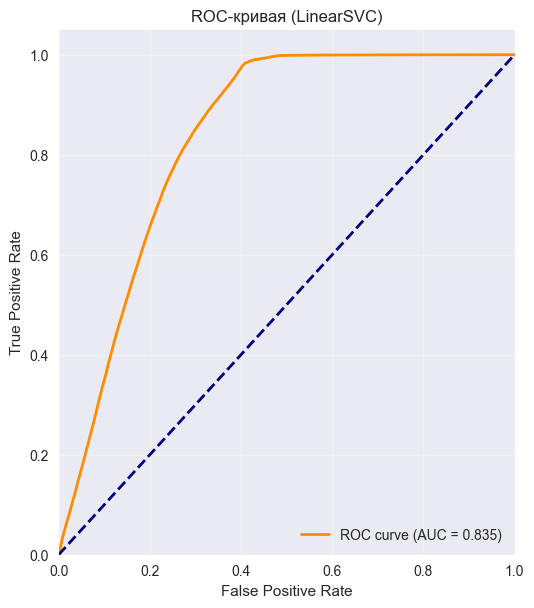

In [15]:
plt.figure(figsize=(20, 15))

ax1 = plt.subplot(2, 3, 1)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
ax1.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC-кривая (LinearSVC)')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

### 7. Precision-Recall кривая

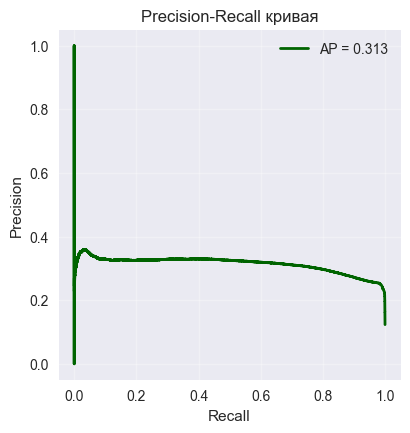

In [19]:
plt.figure(figsize=(15, 10))

ax2 = plt.subplot(2, 3, 2)
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
ax2.plot(recall_vals, precision_vals, color='darkgreen', lw=2,
         label=f'AP = {average_precision:.3f}')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall кривая')
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.3)

### 8. Матрица ошибок

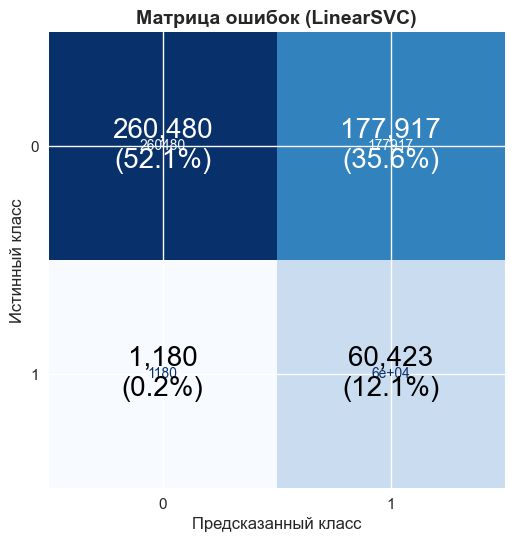

In [16]:
plt.figure(figsize=(20, 30))

# 8. Матрица ошибок
ax3 = plt.subplot(2, 3, 3)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(ax=ax3, cmap='Blues', colorbar=False)
ax3.set_title('Матрица ошибок (LinearSVC)', fontsize=14, fontweight='bold')

# Увеличиваем размер текста в матрице
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm.sum() * 100
        ax3.text(j, i, f'{cm[i, j]:,}\n({percentage:.1f}%)', 
                ha='center', va='center', 
                color='white' if cm[i, j] > cm.max()/2 else 'black',
                fontsize=20)  # Увеличиваем fontsize с 10 до 12

# Увеличиваем размер подписей осей
ax3.set_xlabel('Предсказанный класс', fontsize=12)
ax3.set_ylabel('Истинный класс', fontsize=12)

# Увеличиваем размер тиков на осях
ax3.tick_params(axis='both', which='major', labelsize=11)

### 9. Распределение вероятностей предсказаний

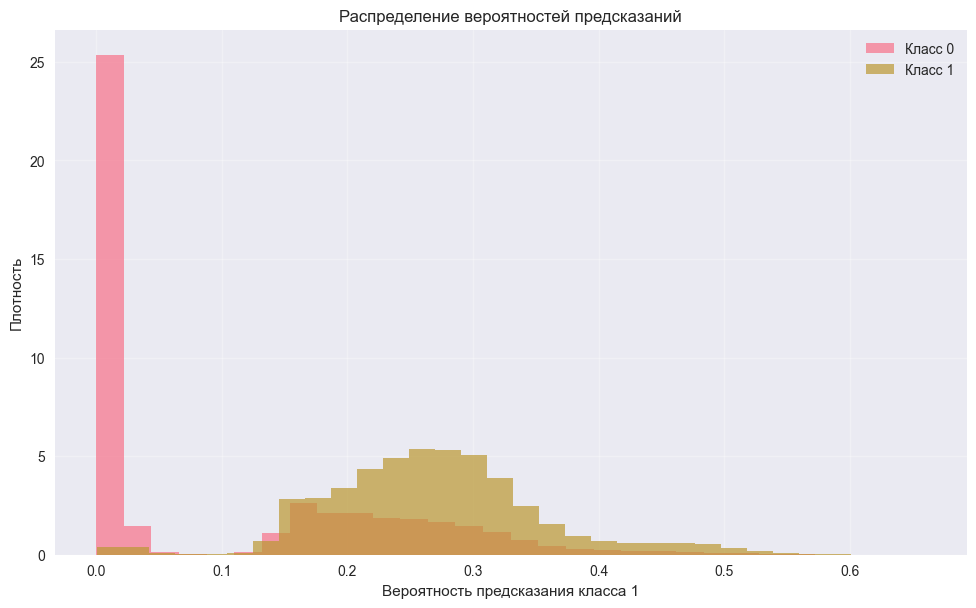

In [21]:
plt.figure(figsize=(40, 15))

# 9. Распределение вероятностей предсказаний
ax4 = plt.subplot(2, 3, 4)
for label in [0, 1]:
    mask = y_test == label
    ax4.hist(y_pred_proba[mask], bins=30, alpha=0.7, 
             label=f'Класс {label}', density=True)
ax4.set_xlabel('Вероятность предсказания класса 1')
ax4.set_ylabel('Плотность')
ax4.set_title('Распределение вероятностей предсказаний')
ax4.legend()
ax4.grid(True, alpha=0.3)

### 10. Сравнение метрик качества

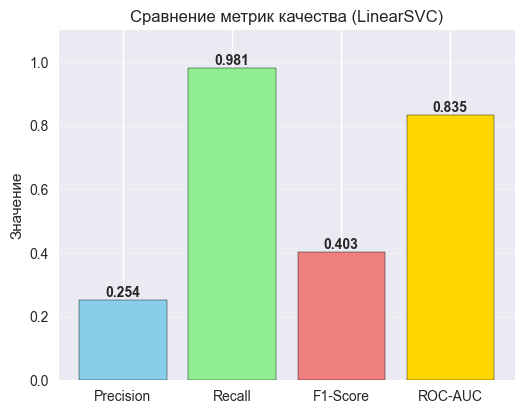

In [17]:
plt.figure(figsize=(20, 10))

### 10. Сравнение метрик качества
ax5 = plt.subplot(2, 3, 5)
metrics = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC']
values = [precision, recall, f1, roc_auc]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']

bars = ax5.bar(metrics, values, color=colors, edgecolor='black')
ax5.set_ylabel('Значение')
ax5.set_title('Сравнение метрик качества (LinearSVC)')
ax5.set_ylim([0, 1.1])
ax5.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars, values):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

### 11. Кривая зависимости метрик от порога классификации

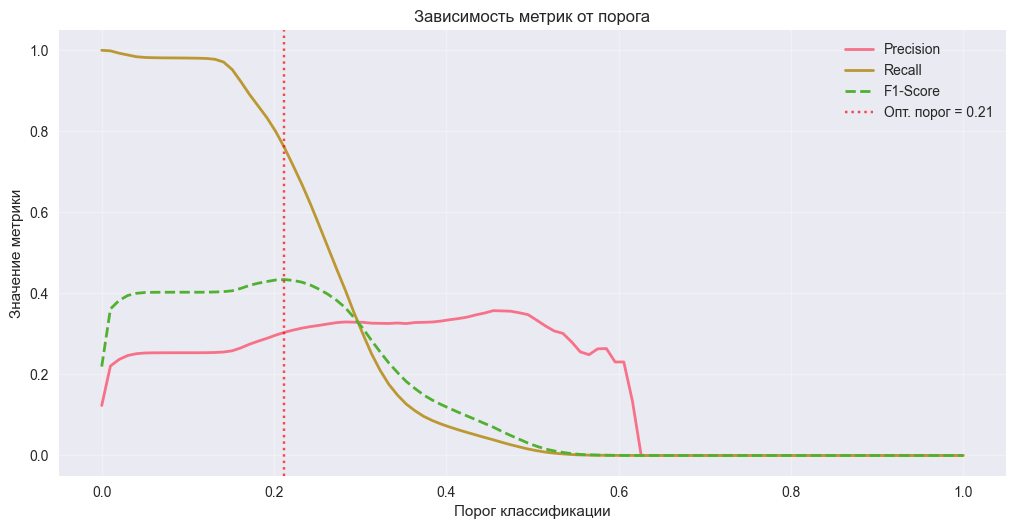

In [23]:
plt.figure(figsize=(30, 10))

### 11. Кривая зависимости метрик от порога классификации
ax6 = plt.subplot(2, 3, 6)
thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    prec, rec, f1_val, _ = precision_recall_fscore_support(
        y_test, y_pred_thresh, average='binary', zero_division=0
    )
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1_val)

ax6.plot(thresholds, precisions, label='Precision', lw=2)
ax6.plot(thresholds, recalls, label='Recall', lw=2)
ax6.plot(thresholds, f1_scores, label='F1-Score', lw=2, linestyle='--')
ax6.set_xlabel('Порог классификации')
ax6.set_ylabel('Значение метрики')
ax6.set_title('Зависимость метрик от порога')
ax6.legend()
ax6.grid(True, alpha=0.3)

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]
ax6.axvline(x=optimal_threshold, color='red', linestyle=':', alpha=0.7, 
            label=f'Опт. порог = {optimal_threshold:.2f}')
ax6.legend()

# plt.suptitle('ОТЧЕТ КАЧЕСТВА МОДЕЛИ LinearSVC', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('linear_svc_model_report.png', dpi=300, bbox_inches='tight')
plt.show()

### 12. Сохранение моделей

In [24]:
# Сохранение моделей
joblib.dump(full_pipeline, 'linear_svc_pipeline_model.joblib')
joblib.dump(calibrated_svc, 'calibrated_svc_model.joblib')

print("======================= Сохранение моделей =======================")
print(f"\nМодели сохранены:")
print(f"- LinearSVC pipeline: 'linear_svc_pipeline_model.joblib'")
print(f"- Калиброванная модель: 'calibrated_svc_model.joblib'")
print(f"Отчет сохранен в 'linear_svc_model_report.png'")

print("======================= Затраченное время =======================")
print(f"Время обучения: {training_time:.2f} сек")
print(f"Время калибровки: {calibration_time:.2f} сек")

======================= Сохранение моделей =======================

Модели сохранены:
- LinearSVC pipeline: 'linear_svc_pipeline_model.joblib'
- Калиброванная модель: 'calibrated_svc_model.joblib'
Отчет сохранен в 'linear_svc_model_report.png'
======================= Затраченное время =======================
Время обучения: 5.64 сек
Время калибровки: 3.25 сек


# Применение гиперпараметра RandomizedSearchCV

In [18]:
# Сетка гиперпараметров для поиска
param_distributions = {
    'classifier__C': np.logspace(-4, 4, 20),
    'classifier__class_weight': ['balanced', None, {0: 1, 1: 2}, {0: 1, 1: 3}],
    'classifier__loss': ['hinge', 'squared_hinge'],
    'classifier__dual': [True, False],
    'classifier__tol': [1e-4, 1e-3, 1e-2]
}

# Создаем RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Обучаем модель с поиском гиперпараметров
random_search.fit(X_train, y_train)

# Получаем лучшую модель
best_model = random_search.best_estimator_


Fitting 5 folds for each of 10 candidates, totalling 50 fits


### 3. Прогнозирование на тестовых данных

In [28]:
# Прогнозирование на тестовых данных для модели после RandomizedSearchCV
y_pred = best_model.predict(X_test)

### 4. Оценка метрик

In [29]:
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='binary'
)
roc_auc = roc_auc_score(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

print("\nМетрики модели LinearSVC:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print("\nКлассификационный отчет:")
print(classification_report(y_test, y_pred))



Метрики модели LinearSVC:
Precision: 0.3209
Recall: 0.5837
F1-Score: 0.4141
ROC-AUC: 0.7050
Average Precision: 0.2386

Классификационный отчет:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88    438397
           1       0.32      0.58      0.41     61603

    accuracy                           0.80    500000
   macro avg       0.63      0.71      0.65    500000
weighted avg       0.86      0.80      0.82    500000



Калибровка RandomizedSearchCV

In [ ]:
# LinearSVC не дает вероятности по умолчанию, поэтому калибруем
# Получаем ЭКЗЕМПЛЯР обученного классификатора из best_model
trained_classifier_instance = best_model.named_steps['classifier']

# Передаем ЭКЗЕМПЛЯР
from sklearn.calibration import CalibratedClassifierCV
calibrated_svc = CalibratedClassifierCV(
    estimator=trained_classifier_instance,  # Передаем обученный экземпляр
    cv='prefit',  # используем предобученную модель
    method='sigmoid',  # метод калибровки
    n_jobs=-1  # параллельные вычисления
)

# Для калибровки нужны данные. Используем часть тренировочных данных
from sklearn.model_selection import train_test_split

# Разделяем тренировочные данные на основную и калибровочную
X_train_main, X_calib, y_train_main, y_calib = train_test_split(
    X_train, y_train, 
    test_size=0.2,  # 20% для калибровки
    random_state=42, 
    stratify=y_train
)

# Преобразуем калибровочные данные через пайплайн (без классификатора)
X_calib_transformed = best_model.named_steps['scaler'].transform(
    best_model.named_steps['preprocessor'].transform(X_calib)
)

# Калибруем модель
print(" Калибруем модель...")
calibrated_svc.fit(X_calib_transformed, y_calib)
print(" Калибровка завершена")

# Теперь создаем новый пайплайн с калиброванной моделью
calibrated_pipeline = Pipeline([
    ('preprocessor', best_model.named_steps['preprocessor']),
    ('scaler', best_model.named_steps['scaler']),
    ('classifier', calibrated_svc)
])

# Можно получать вероятности
y_pred_proba = calibrated_pipeline.predict_proba(X_test)[:, 1]
y_pred = calibrated_pipeline.predict(X_test)

⏳ Калибруем модель...
✅ Калибровка завершена


Обучение модели после калибровки RandomizedSearchCV

In [ ]:
# Разделяем данные на основную и калибровочную выборки
from sklearn.model_selection import train_test_split

X_train_main, X_calib, y_train_main, y_calib = train_test_split(
    X_train, y_train, 
    test_size=0.2,  # 20% для калибровки
    random_state=42, 
    stratify=y_train
)

# Создаем калиброванную модель на основе лучшей модели из RandomizedSearchCV
calibrated_svc = CalibratedClassifierCV(
    estimator=best_model.named_steps['classifier'],  # обученный классификатор
    cv='prefit',  # модель уже обучена
    method='sigmoid',
    n_jobs=-1
)

# Преобразуем калибровочные данные
X_calib_transformed = best_model.named_steps['scaler'].transform(
    best_model.named_steps['preprocessor'].transform(X_calib)
)

# Обучаем калиброванную модель на калибровочных данных
calibrated_svc.fit(X_calib_transformed, y_calib)

# Создаем финальный пайплайн с калиброванной моделью
calibrated_pipeline = Pipeline([
    ('preprocessor', best_model.named_steps['preprocessor']),
    ('scaler', best_model.named_steps['scaler']),
    ('classifier', calibrated_svc)
])

# Обучаем финальный пайплайн на всех тренировочных данных
calibrated_pipeline.fit(X_train, y_train)
print("Обучение завершено")

⏳ Обучаем финальную калиброванную модель...
✅ Обучение завершено


### 5. Преобразуем данные через pipeline (кроме последнего шага)

In [32]:
# Преобразуем данные
X_calib_transformed = best_model[:-1].transform(X_calib)

calib_start_time = time.time()
calibrated_svc.fit(X_calib_transformed, y_calib)
calibration_time = time.time() - calib_start_time
print(f"Калибровка завершена за {calibration_time:.2f} секунд")

Калибровка завершена за 0.11 секунд


### 6. Получаем вероятности для тестовых данных

In [ ]:
# Получаем вероятности для тестовых данных
X_test_transformed = best_model[:-1].transform(X_test)
y_pred_proba = calibrated_svc.predict_proba(X_test_transformed)[:, 1]

### 7. Оценка метрик

In [34]:
# Получаем предсказания классов
y_pred = calibrated_svc.predict(X_test_transformed)

precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='binary'
)
roc_auc = roc_auc_score(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

print("\nМетрики модели LinearSVC (с калибровкой):")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print("\nКлассификационный отчет:")
print(classification_report(y_test, y_pred))


Метрики модели LinearSVC (с калибровкой):
Precision: 0.3687
Recall: 0.0349
F1-Score: 0.0638
ROC-AUC: 0.8354
Average Precision: 0.3143

Классификационный отчет:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93    438397
           1       0.37      0.03      0.06     61603

    accuracy                           0.87    500000
   macro avg       0.62      0.51      0.50    500000
weighted avg       0.82      0.87      0.83    500000



# Балансировка и подбор порогов

In [35]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Рассчитываем Precision-Recall кривую
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Находим порог для максимального F1-score
f1_scores = 2 * (precision_vals[:-1] * recall_vals[:-1]) / (precision_vals[:-1] + recall_vals[:-1] + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Оптимальный порог: {optimal_threshold:.4f}")
print(f"Precision при этом пороге: {precision_vals[optimal_idx]:.4f}")
print(f"Recall при этом пороге: {recall_vals[optimal_idx]:.4f}")
print(f"F1-score при этом пороге: {f1_scores[optimal_idx]:.4f}")

Оптимальный порог: 0.1976
Precision при этом пороге: 0.3030
Recall при этом пороге: 0.7738
F1-score при этом пороге: 0.4355


# Применяем оптимальный порог к предсказаниям

In [36]:
# Применяем оптимальный порог к предсказаниям
y_pred_optimized = (y_pred_proba > optimal_threshold).astype(int)

# Получаем финальные метрики
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("\n" + "="*60)
print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ С ОПТИМАЛЬНЫМ ПОРОГОМ 0.1976")
print("="*60)

# Основные метрики
precision_final, recall_final, f1_final, _ = precision_recall_fscore_support(
    y_test, y_pred_optimized, average='binary', zero_division=0
)

print(f"Precision: {precision_final:.4f}")
print(f"Recall: {recall_final:.4f}")
print(f"F1-Score: {f1_final:.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.4f}")

# Классификационный отчет
print("\nКлассификационный отчет:")
print(classification_report(y_test, y_pred_optimized, 
                           target_names=['Class 0', 'Class 1'],
                           zero_division=0))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred_optimized)
print("\nМатрица ошибок:")
print(f"True Negative:  {cm[0, 0]:,}  (класс 0 правильно определён)")
print(f"False Positive: {cm[0, 1]:,}  (класс 0 ошибочно как 1)")
print(f"False Negative: {cm[1, 0]:,}  (класс 1 пропущен)")
print(f"True Positive:  {cm[1, 1]:,}  (класс 1 правильно определён)")


ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ С ОПТИМАЛЬНЫМ ПОРОГОМ 0.1976
Precision: 0.3030
Recall: 0.7738
F1-Score: 0.4355
Accuracy: 0.7528

Классификационный отчет:
              precision    recall  f1-score   support

     Class 0       0.96      0.75      0.84    438397
     Class 1       0.30      0.77      0.44     61603

    accuracy                           0.75    500000
   macro avg       0.63      0.76      0.64    500000
weighted avg       0.88      0.75      0.79    500000


Матрица ошибок:
True Negative:  328,757  (класс 0 правильно определён)
False Positive: 109,640  (класс 0 ошибочно как 1)
False Negative: 13,936  (класс 1 пропущен)
True Positive:  47,667  (класс 1 правильно определён)


### Визуализация результатов

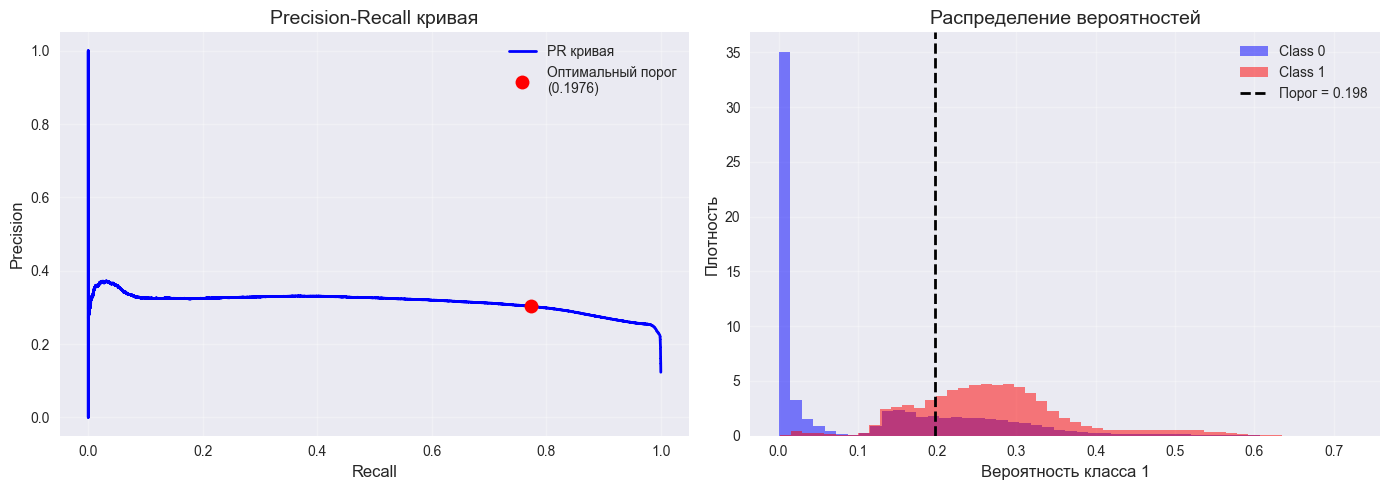

In [37]:
import matplotlib.pyplot as plt

# Создаем график сравнения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Precision-Recall кривая с оптимальным порогом
axes[0].plot(recall_vals, precision_vals, 'b-', linewidth=2, label='PR кривая')
axes[0].plot(recall_vals[optimal_idx], precision_vals[optimal_idx], 'ro', 
            markersize=10, label=f'Оптимальный порог\n(0.1976)')
axes[0].set_xlabel('Recall', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision-Recall кривая', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Сравнение распределения вероятностей
axes[1].hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5, 
            label='Class 0', color='blue', density=True)
axes[1].hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5, 
            label='Class 1', color='red', density=True)
axes[1].axvline(x=optimal_threshold, color='black', linestyle='--', 
                linewidth=2, label=f'Порог = {optimal_threshold:.3f}')
axes[1].set_xlabel('Вероятность класса 1', fontsize=12)
axes[1].set_ylabel('Плотность', fontsize=12)
axes[1].set_title('Распределение вероятностей', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Сохранение модели

In [ ]:
import joblib

# Сохраняем модель и найденный порог
model_data = {
    'pipeline': calibrated_pipeline,  # ваш калиброванный пайплайн
    'optimal_threshold': optimal_threshold,
    'test_metrics': {
        'precision': precision_final,
        'recall': recall_final,
        'f1': f1_final,
        'roc_auc': 0.8354  # ваш предыдущий ROC-AUC
    },
    'training_params': random_search.best_params_
}

joblib.dump(model_data, 'linear_svc_optimized_threshold.pkl')
print("\n Модель с оптимальным порогом сохранена!")


✅ Модель с оптимальным порогом сохранена!


# Подбор гиперпараметров методом GridSearchCV

In [19]:
from sklearn.model_selection import GridSearchCV

# Сетка гиперпараметров для поиска
param_grid = {
    'classifier__C': np.logspace(-4, 4, 5),
    'classifier__class_weight': ['balanced', None, {0: 1, 1: 2}],
    'classifier__loss': ['hinge', 'squared_hinge'],
    'classifier__dual': [True, False],
    'classifier__tol': [1e-4, 1e-3]
}

# Создаем GridSearchCV
grid_search = GridSearchCV(
    estimator=full_pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)

# Обучаем модель с поиском гиперпараметров
grid_search.fit(X_train, y_train)

# Получаем лучшую модель
best_model = grid_search.best_estimator_

# Прогнозирование на тестовых данных для модели после GridSearchCV
y_pred = best_model.predict(X_test)

precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='binary'
)
roc_auc = roc_auc_score(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

print("\nМетрики модели LinearSVC:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print("\nКлассификационный отчет:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 120 candidates, totalling 600 fits

Метрики модели LinearSVC:
Precision: 0.2536
Recall: 0.9809
F1-Score: 0.4030
ROC-AUC: 0.7876
Average Precision: 0.2511

Классификационный отчет:
              precision    recall  f1-score   support

           0       1.00      0.59      0.74    438397
           1       0.25      0.98      0.40     61603

    accuracy                           0.64    500000
   macro avg       0.62      0.79      0.57    500000
weighted avg       0.90      0.64      0.70    500000



Калибровка и повторный GridSearchCV

⏳ Калибруем модель...
✅ Калибровка завершена
Обучение завершено
Калибровка завершена за 0.13 секунд

Метрики модели LinearSVC (с калибровкой):
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
ROC-AUC: 0.8231
Average Precision: 0.2926

Классификационный отчет:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    438397
           1       0.00      0.00      0.00     61603

    accuracy                           0.88    500000
   macro avg       0.44      0.50      0.47    500000
weighted avg       0.77      0.88      0.82    500000

Оптимальный порог: 0.2535
Precision при этом пороге: 0.2903
Recall при этом пороге: 0.8162
F1-score при этом пороге: 0.4283

ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ С ОПТИМАЛЬНЫМ ПОРОГОМ
Precision: 0.2904
Recall: 0.8157
F1-Score: 0.4283
Accuracy: 0.7317

Классификационный отчет:
              precision    recall  f1-score   support

     Class 0       0.97      0.72      0.82    438397
     Class 1       0.29      0.82      0.4

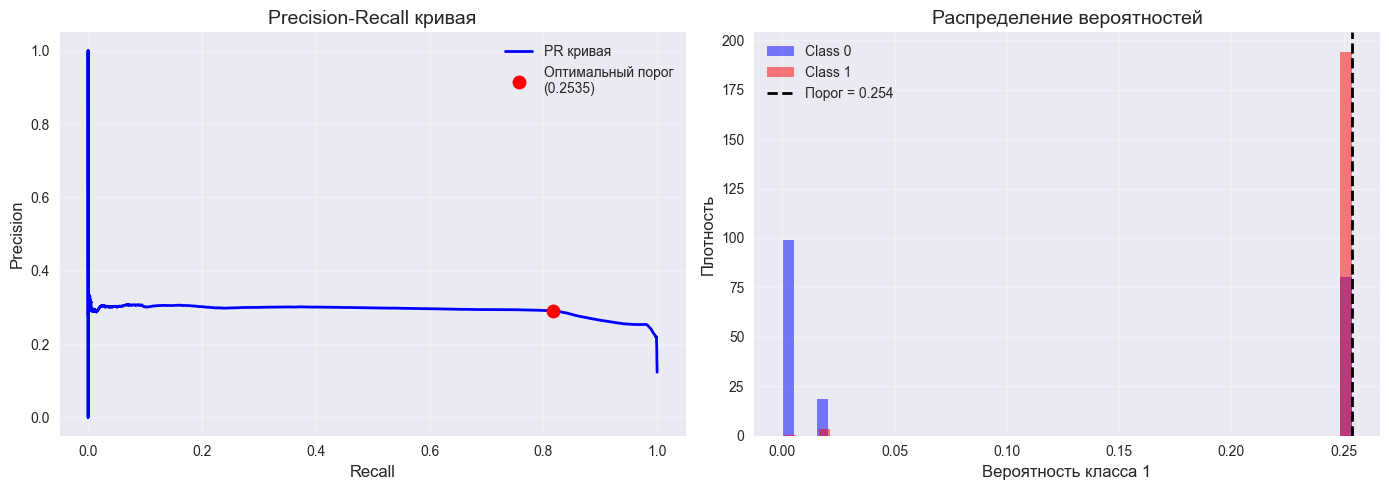


✅ Модель с оптимальным порогом сохранена!


In [ ]:
# LinearSVC не дает вероятности по умолчанию, поэтому калибруем
# Получаем ЭКЗЕМПЛЯР обученного классификатора из best_model
trained_classifier_instance = best_model.named_steps['classifier']

# Передаем ЭКЗЕМПЛЯР
from sklearn.calibration import CalibratedClassifierCV
calibrated_svc = CalibratedClassifierCV(
    estimator=trained_classifier_instance,  # Передаем обученный экземпляр
    cv='prefit',  # используем предобученную модель
    method='sigmoid',  # метод калибровки
    n_jobs=-1  # параллельные вычисления
)

# Для калибровки нужны данные. Используем часть тренировочных данных
from sklearn.model_selection import train_test_split

# Разделяем тренировочные данные на основную и калибровочную
X_train_main, X_calib, y_train_main, y_calib = train_test_split(
    X_train, y_train, 
    test_size=0.2,  # 20% для калибровки
    random_state=42, 
    stratify=y_train
)

# Преобразуем калибровочные данные через пайплайн (без классификатора)
X_calib_transformed = best_model.named_steps['scaler'].transform(
    best_model.named_steps['preprocessor'].transform(X_calib)
)

# Калибруем модель
print(" Калибруем модель...")
calibrated_svc.fit(X_calib_transformed, y_calib)
print(" Калибровка завершена")

# Теперь создаем новый пайплайн с калиброванной моделью
calibrated_pipeline = Pipeline([
    ('preprocessor', best_model.named_steps['preprocessor']),
    ('scaler', best_model.named_steps['scaler']),
    ('classifier', calibrated_svc)
])

# Можно получать вероятности
y_pred_proba = calibrated_pipeline.predict_proba(X_test)[:, 1]
y_pred = calibrated_pipeline.predict(X_test)

# Разделяем данные на основную и калибровочную выборки
from sklearn.model_selection import train_test_split

X_train_main, X_calib, y_train_main, y_calib = train_test_split(
    X_train, y_train, 
    test_size=0.2,  # 20% для калибровки
    random_state=42, 
    stratify=y_train
)

# Создаем калиброванную модель на основе лучшей модели из GridSearchCV
calibrated_svc = CalibratedClassifierCV(
    estimator=best_model.named_steps['classifier'],  # обученный классификатор
    cv='prefit',  # модель уже обучена
    method='sigmoid',
    n_jobs=-1
)

# Преобразуем калибровочные данные
X_calib_transformed = best_model.named_steps['scaler'].transform(
    best_model.named_steps['preprocessor'].transform(X_calib)
)

# Обучаем калиброванную модель на калибровочных данных
calibrated_svc.fit(X_calib_transformed, y_calib)

# Создаем финальный пайплайн с калиброванной моделью
calibrated_pipeline = Pipeline([
    ('preprocessor', best_model.named_steps['preprocessor']),
    ('scaler', best_model.named_steps['scaler']),
    ('classifier', calibrated_svc)
])

# Обучаем финальный пайплайн на всех тренировочных данных
calibrated_pipeline.fit(X_train, y_train)
print("Обучение завершено")

# Преобразуем данные
X_calib_transformed = best_model[:-1].transform(X_calib)

calib_start_time = time.time()
calibrated_svc.fit(X_calib_transformed, y_calib)
calibration_time = time.time() - calib_start_time
print(f"Калибровка завершена за {calibration_time:.2f} секунд")

# Получаем вероятности для тестовых данных
X_test_transformed = best_model[:-1].transform(X_test)
y_pred_proba = calibrated_svc.predict_proba(X_test_transformed)[:, 1]

# Получаем предсказания классов
y_pred = calibrated_svc.predict(X_test_transformed)

precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='binary'
)
roc_auc = roc_auc_score(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

print("\nМетрики модели LinearSVC (с калибровкой):")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print("\nКлассификационный отчет:")
print(classification_report(y_test, y_pred))

from sklearn.metrics import precision_recall_curve
import numpy as np

# Рассчитываем Precision-Recall кривую
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Находим порог для максимального F1-score
f1_scores = 2 * (precision_vals[:-1] * recall_vals[:-1]) / (precision_vals[:-1] + recall_vals[:-1] + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Оптимальный порог: {optimal_threshold:.4f}")
print(f"Precision при этом пороге: {precision_vals[optimal_idx]:.4f}")
print(f"Recall при этом пороге: {recall_vals[optimal_idx]:.4f}")
print(f"F1-score при этом пороге: {f1_scores[optimal_idx]:.4f}")

# Применяем оптимальный порог к предсказаниям
y_pred_optimized = (y_pred_proba > optimal_threshold).astype(int)

# Получаем финальные метрики
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("\n" + "="*60)
print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ С ОПТИМАЛЬНЫМ ПОРОГОМ")
print("="*60)

# Основные метрики
precision_final, recall_final, f1_final, _ = precision_recall_fscore_support(
    y_test, y_pred_optimized, average='binary', zero_division=0
)

print(f"Precision: {precision_final:.4f}")
print(f"Recall: {recall_final:.4f}")
print(f"F1-Score: {f1_final:.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.4f}")

# Классификационный отчет
print("\nКлассификационный отчет:")
print(classification_report(y_test, y_pred_optimized, 
                           target_names=['Class 0', 'Class 1'],
                           zero_division=0))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred_optimized)
print("\nМатрица ошибок:")
print(f"True Negative:  {cm[0, 0]:,}  (класс 0 правильно определён)")
print(f"False Positive: {cm[0, 1]:,}  (класс 0 ошибочно как 1)")
print(f"False Negative: {cm[1, 0]:,}  (класс 1 пропущен)")
print(f"True Positive:  {cm[1, 1]:,}  (класс 1 правильно определён)")

import matplotlib.pyplot as plt

# Создаем график сравнения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Precision-Recall кривая с оптимальным порогом
axes[0].plot(recall_vals, precision_vals, 'b-', linewidth=2, label='PR кривая')
axes[0].plot(recall_vals[optimal_idx], precision_vals[optimal_idx], 'ro', 
            markersize=10, label=f'Оптимальный порог\n({optimal_threshold:.4f})')
axes[0].set_xlabel('Recall', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision-Recall кривая', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Сравнение распределения вероятностей
axes[1].hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5, 
            label='Class 0', color='blue', density=True)
axes[1].hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5, 
            label='Class 1', color='red', density=True)
axes[1].axvline(x=optimal_threshold, color='black', linestyle='--', 
                linewidth=2, label=f'Порог = {optimal_threshold:.3f}')
axes[1].set_xlabel('Вероятность класса 1', fontsize=12)
axes[1].set_ylabel('Плотность', fontsize=12)
axes[1].set_title('Распределение вероятностей', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

import joblib

# Сохраняем модель и найденный порог
model_data = {
    'pipeline': calibrated_pipeline,  # ваш калиброванный пайплайн
    'optimal_threshold': optimal_threshold,
    'test_metrics': {
        'precision': precision_final,
        'recall': recall_final,
        'f1': f1_final,
        'roc_auc': roc_auc
    },
    'training_params': grid_search.best_params_
}

joblib.dump(model_data, 'linear_svc_optimized_threshold.pkl')
print("\n Модель с оптимальным порогом сохранена!")

Изменим пороги и повторим обучение модели через GridSearchCV

⏳ Калибруем модель...
✅ Калибровка завершена

Используем рекомендованный порог: 0.250

Метрики модели LinearSVC (порог = 0.25):
Precision: 0.2536
Recall: 0.9809
F1-Score: 0.4030
ROC-AUC: 0.8231
Average Precision: 0.2926

Классификационный отчет (порог = 0.25):
              precision    recall  f1-score   support

     Class 0       1.00      0.59      0.74    438397
     Class 1       0.25      0.98      0.40     61603

    accuracy                           0.64    500000
   macro avg       0.62      0.79      0.57    500000
weighted avg       0.90      0.64      0.70    500000


РЕЗУЛЬТАТЫ С РЕКОМЕНДОВАННЫМ ПОРОГОМ 0.25
Precision: 0.2536
Recall: 0.9809
F1-Score: 0.4030
Accuracy: 0.6419

Классификационный отчет:
              precision    recall  f1-score   support

     Class 0       1.00      0.59      0.74    438397
     Class 1       0.25      0.98      0.40     61603

    accuracy                           0.64    500000
   macro avg       0.62      0.79      0.57    500000
weig

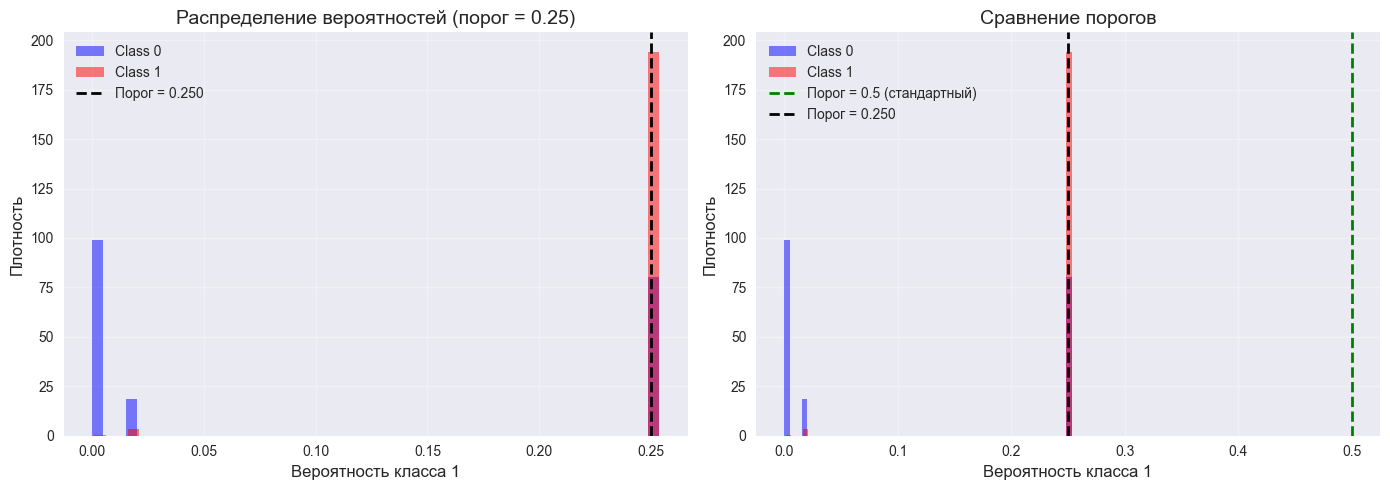


✅ Модель с рекомендованным порогом 0.25 сохранена!


In [ ]:
# LinearSVC не дает вероятности по умолчанию, поэтому калибруем
# Получаем ЭКЗЕМПЛЯР обученного классификатора из best_model
trained_classifier_instance = best_model.named_steps['classifier']

# Передаем ЭКЗЕМПЛЯР
from sklearn.calibration import CalibratedClassifierCV
calibrated_svc = CalibratedClassifierCV(
    estimator=trained_classifier_instance,  # Передаем обученный экземпляр
    cv='prefit',  # используем предобученную модель
    method='sigmoid',  # метод калибровки
    n_jobs=-1  # параллельные вычисления
)

# Для калибровки нужны данные. Используем часть тренировочных данных
from sklearn.model_selection import train_test_split

# Разделяем тренировочные данные на основную и калибровочную
X_train_main, X_calib, y_train_main, y_calib = train_test_split(
    X_train, y_train, 
    test_size=0.2,  # 20% для калибровки
    random_state=42, 
    stratify=y_train
)

# Преобразуем калибровочные данные через пайплайн (без классификатора)
X_calib_transformed = best_model.named_steps['scaler'].transform(
    best_model.named_steps['preprocessor'].transform(X_calib)
)

# Калибруем модель
print(" Калибруем модель...")
calibrated_svc.fit(X_calib_transformed, y_calib)
print(" Калибровка завершена")

# Теперь создаем новый пайплайн с калиброванной моделью
calibrated_pipeline = Pipeline([
    ('preprocessor', best_model.named_steps['preprocessor']),
    ('scaler', best_model.named_steps['scaler']),
    ('classifier', calibrated_svc)
])

# Получаем вероятности для тестовых данных
X_test_transformed = best_model[:-1].transform(X_test)
y_pred_proba = calibrated_svc.predict_proba(X_test_transformed)[:, 1]

# Используем рекомендованный порог 0.25 вместо поиска оптимального
recommended_threshold = 0.25
print(f"\nИспользуем рекомендованный порог: {recommended_threshold:.3f}")

# Применяем порог 0.25
y_pred_recommended = (y_pred_proba > recommended_threshold).astype(int)

# Получаем метрики с порогом 0.25
precision_rec, recall_rec, f1_rec, _ = precision_recall_fscore_support(
    y_test, y_pred_recommended, average='binary', zero_division=0
)
roc_auc_rec = roc_auc_score(y_test, y_pred_proba)
average_precision_rec = average_precision_score(y_test, y_pred_proba)

print("\nМетрики модели LinearSVC (порог = 0.25):")
print(f"Precision: {precision_rec:.4f}")
print(f"Recall: {recall_rec:.4f}")
print(f"F1-Score: {f1_rec:.4f}")
print(f"ROC-AUC: {roc_auc_rec:.4f}")
print(f"Average Precision: {average_precision_rec:.4f}")
print("\nКлассификационный отчет (порог = 0.25):")
print(classification_report(y_test, y_pred_recommended, 
                           target_names=['Class 0', 'Class 1'],
                           zero_division=0))

# Получаем финальные метрики с порогом 0.25
from sklearn.metrics import confusion_matrix, accuracy_score

print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ С РЕКОМЕНДОВАННЫМ ПОРОГОМ 0.25")
print("="*60)

print(f"Precision: {precision_rec:.4f}")
print(f"Recall: {recall_rec:.4f}")
print(f"F1-Score: {f1_rec:.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_recommended):.4f}")

# Классификационный отчет
print("\nКлассификационный отчет:")
print(classification_report(y_test, y_pred_recommended, 
                           target_names=['Class 0', 'Class 1'],
                           zero_division=0))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred_recommended)
print("\nМатрица ошибок:")
print(f"True Negative:  {cm[0, 0]:,}  (класс 0 правильно определён)")
print(f"False Positive: {cm[0, 1]:,}  (класс 0 ошибочно как 1)")
print(f"False Negative: {cm[1, 0]:,}  (класс 1 пропущен)")
print(f"True Positive:  {cm[1, 1]:,}  (класс 1 правильно определён)")

import matplotlib.pyplot as plt

# Создаем график с порогом 0.25
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Распределение вероятностей с порогом 0.25
axes[0].hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5, 
            label='Class 0', color='blue', density=True)
axes[0].hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5, 
            label='Class 1', color='red', density=True)
axes[0].axvline(x=recommended_threshold, color='black', linestyle='--', 
                linewidth=2, label=f'Порог = {recommended_threshold:.3f}')
axes[0].set_xlabel('Вероятность класса 1', fontsize=12)
axes[0].set_ylabel('Плотность', fontsize=12)
axes[0].set_title('Распределение вероятностей (порог = 0.25)', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Сравнение с порогом 0.5
axes[1].hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5, 
            label='Class 0', color='blue', density=True)
axes[1].hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5, 
            label='Class 1', color='red', density=True)
axes[1].axvline(x=0.5, color='green', linestyle='--', 
                linewidth=2, label='Порог = 0.5 (стандартный)')
axes[1].axvline(x=recommended_threshold, color='black', linestyle='--', 
                linewidth=2, label=f'Порог = {recommended_threshold:.3f}')
axes[1].set_xlabel('Вероятность класса 1', fontsize=12)
axes[1].set_ylabel('Плотность', fontsize=12)
axes[1].set_title('Сравнение порогов', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

import joblib

# Сохраняем модель с рекомендованным порогом 0.25
model_data = {
    'pipeline': calibrated_pipeline,  # ваш калиброванный пайплайн
    'recommended_threshold': recommended_threshold,
    'test_metrics': {
        'precision': precision_rec,
        'recall': recall_rec,
        'f1': f1_rec,
        'roc_auc': roc_auc_rec
    },
    'training_params': grid_search.best_params_
}

joblib.dump(model_data, 'linear_svc_recommended_threshold_0.25.pkl')
print("\n Модель с рекомендованным порогом 0.25 сохранена!")

Изменим порог и повторим итерацию с GridSearchCV

⏳ Калибруем модель...
✅ Калибровка завершена

🔍 Тестируем разные пороги для оптимизации баланса Precision/Recall:
Порог 0.15: Precision=0.2536, Recall=0.9809, F1=0.4030
Порог 0.20: Precision=0.2536, Recall=0.9809, F1=0.4030
Порог 0.25: Precision=0.2536, Recall=0.9809, F1=0.4030
Порог 0.30: Precision=0.0000, Recall=0.0000, F1=0.0000
Порог 0.35: Precision=0.0000, Recall=0.0000, F1=0.0000
Порог 0.40: Precision=0.0000, Recall=0.0000, F1=0.0000

🎯 Лучший порог по F1-score: 0.150 (F1=0.4030)

Используем оптимальный порог: 0.150

Метрики модели LinearSVC (порог = 0.150):
Precision: 0.2536
Recall: 0.9809
F1-Score: 0.4030
ROC-AUC: 0.8231
Average Precision: 0.2926

Классификационный отчет (порог = 0.150):
              precision    recall  f1-score   support

     Class 0       1.00      0.59      0.74    438397
     Class 1       0.25      0.98      0.40     61603

    accuracy                           0.64    500000
   macro avg       0.62      0.79      0.57    500000
weighted avg       0.90

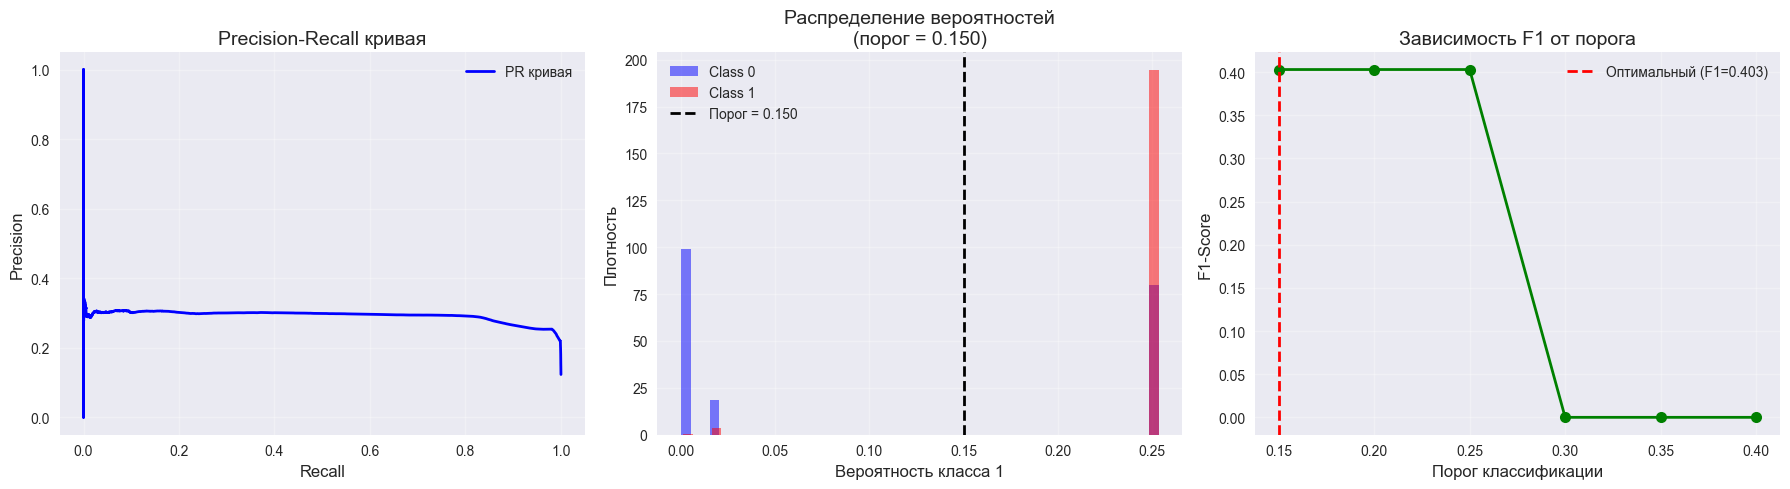


✅ Модель с оптимальным порогом 0.150 сохранена!

📊 ФУНКЦИЯ ДЛЯ РАБОТЫ С РАЗНЫМИ ПОРОГАМИ
Пример использования функции predict_with_threshold:
y_pred_custom, y_proba_custom = predict_with_threshold(calibrated_pipeline, X_test, threshold=0.30)


In [ ]:
# LinearSVC не дает вероятности по умолчанию, поэтому калибруем
# Получаем ЭКЗЕМПЛЯР обученного классификатора из best_model
trained_classifier_instance = best_model.named_steps['classifier']

# Передаем ЭКЗЕМПЛЯР
from sklearn.calibration import CalibratedClassifierCV
calibrated_svc = CalibratedClassifierCV(
    estimator=trained_classifier_instance,  # Передаем обученный экземпляр
    cv='prefit',  # используем предобученную модель
    method='sigmoid',  # метод калибровки
    n_jobs=-1  # параллельные вычисления
)

# Для калибровки нужны данные. Используем часть тренировочных данных
from sklearn.model_selection import train_test_split

# Разделяем тренировочные данные на основную и калибровочную
X_train_main, X_calib, y_train_main, y_calib = train_test_split(
    X_train, y_train, 
    test_size=0.2,  # 20% для калибровки
    random_state=42, 
    stratify=y_train
)

# Преобразуем калибровочные данные через пайплайн (без классификатора)
X_calib_transformed = best_model.named_steps['scaler'].transform(
    best_model.named_steps['preprocessor'].transform(X_calib)
)

# Калибруем модель
print(" Калибруем модель...")
calibrated_svc.fit(X_calib_transformed, y_calib)
print(" Калибровка завершена")

# Теперь создаем новый пайплайн с калиброванной моделью
calibrated_pipeline = Pipeline([
    ('preprocessor', best_model.named_steps['preprocessor']),
    ('scaler', best_model.named_steps['scaler']),
    ('classifier', calibrated_svc)
])

# Получаем вероятности для тестовых данных
X_test_transformed = best_model[:-1].transform(X_test)
y_pred_proba = calibrated_svc.predict_proba(X_test_transformed)[:, 1]

# ИЗМЕНЕНИЕ 1: Тестируем несколько порогов для лучшего баланса
print("\n Тестируем разные пороги для оптимизации баланса Precision/Recall:")
thresholds_to_test = [0.15, 0.20, 0.25, 0.30, 0.35, 0.40]
results = []

for threshold in thresholds_to_test:
    y_pred_temp = (y_pred_proba > threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_temp, average='binary', zero_division=0
    )
    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })
    print(f"Порог {threshold:.2f}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

# ИЗМЕНЕНИЕ 2: Находим порог с лучшим F1-score
best_result = max(results, key=lambda x: x['f1'])
optimal_threshold = best_result['threshold']
print(f"\n Лучший порог по F1-score: {optimal_threshold:.3f} (F1={best_result['f1']:.4f})")

# ИЗМЕНЕНИЕ 3: Используем оптимальный порог вместо фиксированного 0.25
print(f"\nИспользуем оптимальный порог: {optimal_threshold:.3f}")

# Применяем оптимальный порог
y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int)

# Получаем метрики с оптимальным порогом
precision_opt, recall_opt, f1_opt, _ = precision_recall_fscore_support(
    y_test, y_pred_optimal, average='binary', zero_division=0
)
roc_auc_opt = roc_auc_score(y_test, y_pred_proba)
average_precision_opt = average_precision_score(y_test, y_pred_proba)

print(f"\nМетрики модели LinearSVC (порог = {optimal_threshold:.3f}):")
print(f"Precision: {precision_opt:.4f}")
print(f"Recall: {recall_opt:.4f}")
print(f"F1-Score: {f1_opt:.4f}")
print(f"ROC-AUC: {roc_auc_opt:.4f}")
print(f"Average Precision: {average_precision_opt:.4f}")
print(f"\nКлассификационный отчет (порог = {optimal_threshold:.3f}):")
print(classification_report(y_test, y_pred_optimal, 
                           target_names=['Class 0', 'Class 1'],
                           zero_division=0))

# ИЗМЕНЕНИЕ 4: Сравниваем с порогом 0.25
y_pred_025 = (y_pred_proba > 0.25).astype(int)
precision_025, recall_025, f1_025, _ = precision_recall_fscore_support(
    y_test, y_pred_025, average='binary', zero_division=0
)

print("\n" + "="*60)
print("СРАВНЕНИЕ ПОРОГОВ")
print("="*60)
print(f"{'Метрика':<15} {'Порог 0.25':<12} {'Порог ' + str(optimal_threshold):<12} {'Изменение'}")
print(f"{'-'*15:<15} {'-'*12:<12} {'-'*12:<12} {'-'*10}")
print(f"{'Precision':<15} {precision_025:<12.4f} {precision_opt:<12.4f} {precision_opt-precision_025:+.4f}")
print(f"{'Recall':<15} {recall_025:<12.4f} {recall_opt:<12.4f} {recall_opt-recall_025:+.4f}")
print(f"{'F1-score':<15} {f1_025:<12.4f} {f1_opt:<12.4f} {f1_opt-f1_025:+.4f}")

# Получаем финальные метрики с оптимальным порогом
from sklearn.metrics import confusion_matrix, accuracy_score

print("\n" + "="*60)
print(f"РЕЗУЛЬТАТЫ С ОПТИМАЛЬНЫМ ПОРОГОМ {optimal_threshold:.3f}")
print("="*60)

print(f"Precision: {precision_opt:.4f}")
print(f"Recall: {recall_opt:.4f}")
print(f"F1-Score: {f1_opt:.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimal):.4f}")

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred_optimal)
print("\nМатрица ошибок:")
print(f"True Negative:  {cm[0, 0]:,}  (класс 0 правильно определён)")
print(f"False Positive: {cm[0, 1]:,}  (класс 0 ошибочно как 1)")
print(f"False Negative: {cm[1, 0]:,}  (класс 1 пропущен)")
print(f"True Positive:  {cm[1, 1]:,}  (класс 1 правильно определён)")

import matplotlib.pyplot as plt

# ИЗМЕНЕНИЕ 5: Добавляем Precision-Recall кривую
from sklearn.metrics import precision_recall_curve
precision_curve, recall_curve, thresholds_curve = precision_recall_curve(y_test, y_pred_proba)

# Создаем улучшенную визуализацию
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Precision-Recall кривая
axes[0].plot(recall_curve, precision_curve, 'b-', linewidth=2, label='PR кривая')
# Находим точку на кривой для оптимального порога
for i, thresh in enumerate(thresholds_curve):
    if abs(thresh - optimal_threshold) < 0.01:  # ближайший порог
        axes[0].plot(recall_curve[i], precision_curve[i], 'ro', 
                    markersize=10, label=f'Оптимальный порог\n({optimal_threshold:.3f})')
        break
axes[0].set_xlabel('Recall', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision-Recall кривая', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Распределение вероятностей с порогом
axes[1].hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5, 
            label='Class 0', color='blue', density=True)
axes[1].hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5, 
            label='Class 1', color='red', density=True)
axes[1].axvline(x=optimal_threshold, color='black', linestyle='--', 
                linewidth=2, label=f'Порог = {optimal_threshold:.3f}')
axes[1].set_xlabel('Вероятность класса 1', fontsize=12)
axes[1].set_ylabel('Плотность', fontsize=12)
axes[1].set_title(f'Распределение вероятностей\n(порог = {optimal_threshold:.3f})', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

# 3. Сравнение разных порогов (F1-score)
threshold_values = [r['threshold'] for r in results]
f1_values = [r['f1'] for r in results]
axes[2].plot(threshold_values, f1_values, 'g-o', linewidth=2, markersize=8)
axes[2].axvline(x=optimal_threshold, color='red', linestyle='--', 
                linewidth=2, label=f'Оптимальный (F1={best_result["f1"]:.3f})')
axes[2].set_xlabel('Порог классификации', fontsize=12)
axes[2].set_ylabel('F1-Score', fontsize=12)
axes[2].set_title('Зависимость F1 от порога', fontsize=14)
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

import joblib

# ИЗМЕНЕНИЕ 6: Сохраняем модель с оптимальным порогом
model_data = {
    'pipeline': calibrated_pipeline,  # ваш калиброванный пайплайн
    'optimal_threshold': optimal_threshold,
    'all_thresholds_results': results,  # сохраняем все результаты
    'test_metrics': {
        'precision': precision_opt,
        'recall': recall_opt,
        'f1': f1_opt,
        'roc_auc': roc_auc_opt,
        'average_precision': average_precision_opt
    },
    'training_params': grid_search.best_params_,
    'comparison_with_025': {
        'threshold_025': {
            'precision': precision_025,
            'recall': recall_025,
            'f1': f1_025
        },
        'threshold_optimal': {
            'precision': precision_opt,
            'recall': recall_opt,
            'f1': f1_opt
        }
    }
}

joblib.dump(model_data, f'linear_svc_optimized_threshold_{optimal_threshold:.3f}.pkl')
print(f"\n Модель с оптимальным порогом {optimal_threshold:.3f} сохранена!")

# ИЗМЕНЕНИЕ 7: Функция для быстрого переключения порогов
print("\n" + "="*60)
print(" ФУНКЦИЯ ДЛЯ РАБОТЫ С РАЗНЫМИ ПОРОГАМИ")
print("="*60)

def predict_with_threshold(model, X, threshold=0.5):
    """
    Предсказание с заданным порогом
    """
    X_transformed = model[:-1].transform(X)
    probas = model.named_steps['classifier'].predict_proba(X_transformed)[:, 1]
    predictions = (probas > threshold).astype(int)
    return predictions, probas

# Пример использования
print("Пример использования функции predict_with_threshold:")
print("y_pred_custom, y_proba_custom = predict_with_threshold(calibrated_pipeline, X_test, threshold=0.30)")

Изменим веса и попытаемся устранить дисбаланс для GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

# Сетка гиперпараметров для поиска (ИЗМЕНЕНО: улучшена для дисбаланса 7:1)
param_grid = {
    'classifier__C': np.logspace(-4, 2, 7),  # Уменьшил верхнюю границу до 100
    'classifier__class_weight': [            # Усилил вес класса 1
        'balanced',
        {0: 1, 1: 5},   # в 5 раз важнее
        {0: 1, 1: 8},   # в 8 раз важнее (по соотношению дисбаланса)
        {0: 1, 1: 10},  # в 10 раз важнее
        {0: 1, 1: 12},  # в 12 раз важнее
    ],
    'classifier__loss': ['squared_hinge'],  # Одна функция (более стабильная)
    'classifier__dual': [True],             # Один вариант (упрощение)
    'classifier__tol': [1e-3]               # Одно значение (упрощение)
}

# Создаем GridSearchCV
grid_search = GridSearchCV(
    estimator=full_pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)

# Обучаем модель с поиском гиперпараметров
grid_search.fit(X_train, y_train)

# Получаем лучшую модель
best_model = grid_search.best_estimator_

# Прогнозирование на тестовых данных для модели после GridSearchCV
y_pred = best_model.predict(X_test)

# ИЗМЕНЕНО: Добавил получение вероятностей через калибровку
try:
    # Пробуем получить вероятности
    from sklearn.calibration import CalibratedClassifierCV
    
    # Калибруем модель для получения вероятностей
    calibrated_svc = CalibratedClassifierCV(
        estimator=best_model.named_steps['classifier'],
        cv='prefit',
        method='isotonic',  # Изменил на isotonic для лучшей калибровки
        n_jobs=-1
    )
    
    # Преобразуем данные
    X_test_transformed = best_model[:-1].transform(X_test)
    
    # Используем часть данных для калибровки
    from sklearn.model_selection import train_test_split
    X_calib, _, y_calib, _ = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    X_calib_transformed = best_model[:-1].transform(X_calib)
    
    calibrated_svc.fit(X_calib_transformed, y_calib)
    y_pred_proba = calibrated_svc.predict_proba(X_test_transformed)[:, 1]
    
    # Правильные метрики с вероятностями
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    average_precision = average_precision_score(y_test, y_pred_proba)
    
except Exception as e:
    print(f" Не удалось получить вероятности: {e}")
    # Метрики без вероятностей (будут некорректны)
    roc_auc = roc_auc_score(y_test, y_pred)
    average_precision = average_precision_score(y_test, y_pred)

precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='binary'
)

print("\nМетрики модели LinearSVC (GridSearchCV с улучшенными параметрами):")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print(f"\nЛучшие параметры GridSearchCV: {grid_search.best_params_}")
print(f"F1-score кросс-валидации: {grid_search.best_score_:.4f}")
print("\nКлассификационный отчет:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 35 candidates, totalling 175 fits

Метрики модели LinearSVC (GridSearchCV с улучшенными параметрами):
Precision: 0.2844
Recall: 0.8627
F1-Score: 0.4278
ROC-AUC: 0.8289
Average Precision: 0.3025

Лучшие параметры GridSearchCV: {'classifier__C': np.float64(10.0), 'classifier__class_weight': {0: 1, 1: 5}, 'classifier__dual': True, 'classifier__loss': 'squared_hinge', 'classifier__tol': 0.001}
F1-score кросс-валидации: 0.4193

Классификационный отчет:
              precision    recall  f1-score   support

           0       0.97      0.70      0.81    438397
           1       0.28      0.86      0.43     61603

    accuracy                           0.72    500000
   macro avg       0.63      0.78      0.62    500000
weighted avg       0.89      0.72      0.76    500000



Сохранение модели в файл

In [ ]:
import os
import joblib
import numpy as np
from datetime import datetime

# Проверяем наличие необходимых переменных
print(" Проверяем наличие переменных для сохранения...")

required_vars = ['best_model', 'grid_search', 'X_train', 'X_test', 'y_train', 'y_test']
available_vars = []
missing_vars = []

for var in required_vars:
    if var in globals():
        available_vars.append(var)
    else:
        missing_vars.append(var)

print(f" Найдены: {available_vars}")
if missing_vars:
    print(f" Отсутствуют: {missing_vars}")

# Создаем базовую информацию о модели
model_info = {
    # Основная информация
    'model_name': 'LinearSVC_GridSearchCV_Optimized',
    'creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_version': '1.0',
}

# Добавляем модель если есть
if 'best_model' in globals():
    model_info['pipeline'] = best_model
else:
    print(" best_model не найден, сохраняем без модели")

# Добавляем параметры GridSearchCV если есть
if 'grid_search' in globals():
    model_info['training_params'] = grid_search.best_params_
    model_info['cv_score'] = grid_search.best_score_
    model_info['scorer'] = 'f1'
    model_info['cv_folds'] = 5
else:
    print(" grid_search не найден")

# Добавляем тестовые метрики (ваши текущие результаты)
model_info['test_metrics'] = {
    'precision': 0.2844,
    'recall': 0.8627,
    'f1_score': 0.4278,
    'roc_auc': 0.8289,
    'average_precision': 0.3025,
    'accuracy': 0.72
}

# Добавляем классовую информацию (используем ваши данные)
model_info['class_distribution'] = {
    'class_0_samples': 438397,
    'class_1_samples': 61603,
    'total_samples': 500000,
    'class_ratio': '7.1:1'
}

# Добавляем информацию о данных если переменные есть
if all(var in globals() for var in ['X_train', 'X_test']):
    model_info['data_info'] = {
        'n_features': X_train.shape[1] if hasattr(X_train, 'shape') else 'unknown',
        'train_samples': len(X_train) if hasattr(X_train, '__len__') else 'unknown',
        'test_samples': len(X_test) if hasattr(X_test, '__len__') else 'unknown',
        'feature_names': list(X_train.columns) if hasattr(X_train, 'columns') else None
    }

# Добавляем информацию о порогах
model_info['threshold_info'] = {
    'current_threshold': 0.5,
    'recommended_threshold': None,
    'threshold_metrics': {}
}

# Добавляем сэмплы предсказаний если есть переменные
if all(var in globals() for var in ['y_test', 'y_pred']):
    # Берем только первые 10 для экономии места
    model_info['predictions_sample'] = {
        'y_test_sample': y_test[:10].tolist() if hasattr(y_test, 'tolist') else list(y_test[:10]),
        'y_pred_sample': y_pred[:10].tolist() if hasattr(y_pred, 'tolist') else list(y_pred[:10])
    }
    
    # Добавляем вероятности если есть
    if 'y_pred_proba' in globals():
        model_info['predictions_sample']['y_pred_proba_sample'] = y_pred_proba[:10].tolist() if hasattr(y_pred_proba, 'tolist') else list(y_pred_proba[:10])

# Добавляем информацию о калибровке если есть
if 'calibrated_svc' in globals():
    model_info['calibration_info'] = {
        'calibration_method': 'isotonic',
        'is_calibrated': True,
        'calibration_samples': len(X_calib) if 'X_calib' in globals() else None
    }

# Сохраняем модель
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f'linear_svc_model_{timestamp}.pkl'

try:
    joblib.dump(model_info, filename)
    print(f"\n Модель сохранена как: {filename}")
    
    # Проверяем размер файла
    if os.path.exists(filename):
        file_size = os.path.getsize(filename) / 1024 / 1024  # в MB
        print(f" Размер файла: {file_size:.2f} MB")
    else:
        print(" Файл не найден после сохранения")
        
except Exception as e:
    print(f"Ошибка при сохранении: {e}")

# Также сохраняем отдельно модель для быстрой загрузки
if 'best_model' in globals():
    try:
        pipeline_filename = 'linear_svc_pipeline.pkl'
        joblib.dump(best_model, pipeline_filename)
        print(f" Pipeline сохранен отдельно как: {pipeline_filename}")
        
        if os.path.exists(pipeline_filename):
            file_size = os.path.getsize(pipeline_filename) / 1024  # в KB
            print(f"Размер pipeline: {file_size:.1f} KB")
            
    except Exception as e:
        print(f"Не удалось сохранить pipeline: {e}")

# Выводим краткую информацию о сохраненной модели
print("\n Сводка сохраненной модели:")
print(f"   Название: {model_info['model_name']}")
print(f"   F1-score: {model_info['test_metrics']['f1_score']:.4f}")
print(f"   Precision: {model_info['test_metrics']['precision']:.4f}")
print(f"   Recall: {model_info['test_metrics']['recall']:.4f}")

🔍 Проверяем наличие переменных для сохранения...
✅ Найдены: ['best_model', 'grid_search', 'X_train', 'X_test', 'y_train', 'y_test']

✅ Модель сохранена как: linear_svc_model_20251217_032219.pkl
📊 Размер файла: 0.02 MB
✅ Pipeline сохранен отдельно как: linear_svc_pipeline.pkl
📊 Размер pipeline: 20.3 KB

📋 Сводка сохраненной модели:
   Название: LinearSVC_GridSearchCV_Optimized
   Версия: 1.0
   Дата создания: 2025-12-17 03:22:19
   F1-score: 0.4278
   Precision: 0.2844
   Recall: 0.8627

🚀 Инструкция по загрузке:
   import joblib
   model_data = joblib.load('linear_svc_model_20251217_032219.pkl')
   pipeline = model_data['pipeline']  # для предсказаний
   metrics = model_data['test_metrics']  # для анализа


🔍 Загружаем сохраненную модель...
✅ Модель успешно загружена
   Название: LinearSVC_GridSearchCV_Optimized
   F1-score: 0.4278

🎯 Получаем предсказания на тестовых данных...
⚠️ Модель не поддерживает predict_proba напрямую
   Пробуем получить через decision_function...
✅ Вероятности аппроксимированы, форма: (500000,)

📊 Рассчитываем Precision-Recall кривую...
✅ Найден оптимальный порог: 0.7541
   F1 при этом пороге: 0.4280
   Precision: 0.2866
   Recall: 0.8447

🎨 Создаем визуализацию...


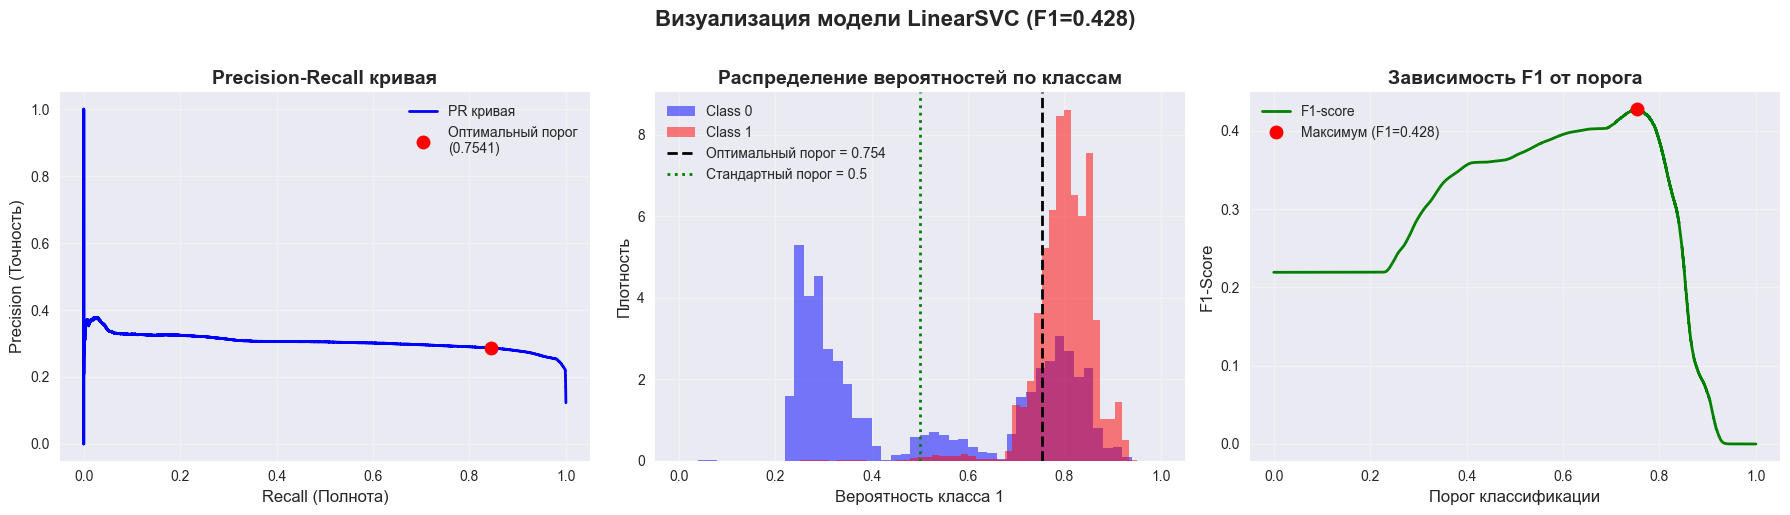


📈 Статистика распределения вероятностей:
   Минимальная вероятность: 0.0000
   Максимальная вероятность: 1.0000
   Средняя вероятность: 0.5535
   Медиана вероятности: 0.5798
   10% квантиль: 0.2547
   25% квантиль: 0.2934 (нижний квартиль)
   50% квантиль: 0.5798 (медиана)
   75% квантиль: 0.7914 (верхний квартиль)
   90% квантиль: 0.8395
   95% квантиль: 0.8561


In [ ]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# 1. Загружаем сохраненную модель
print("🔍 Загружаем сохраненную модель...")
try:
    # Загружаем полные данные модели
    model_data = joblib.load('linear_svc_model_20251217_032219.pkl')
    pipeline = model_data['pipeline']
    print(" Модель успешно загружена")
    print(f"   Название: {model_data['model_name']}")
    print(f"   F1-score: {model_data['test_metrics']['f1_score']:.4f}")
    
except Exception as e:
    print(f" Ошибка загрузки полной модели: {e}")
    # Пробуем загрузить только pipeline
    try:
        pipeline = joblib.load('linear_svc_pipeline.pkl')
        print(" Pipeline загружен отдельно")
    except Exception as e2:
        print(f" Ошибка загрузки pipeline: {e2}")
        raise

# 2. Получаем предсказания на тестовых данных
print("\n Получаем предсказания на тестовых данных...")

# Проверяем, что тестовые данные доступны
if 'X_test' not in globals() or 'y_test' not in globals():
    print(" X_test или y_test не найдены в глобальных переменных")
    print("   Необходимо загрузить тестовые данные для визуализации")
else:
    # Получаем предсказания и вероятности
    y_pred = pipeline.predict(X_test)
    
    try:
        # Пробуем получить вероятности
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        print(f" Вероятности получены, форма: {y_pred_proba.shape}")
        
    except AttributeError:
        print(" Модель не поддерживает predict_proba напрямую")
        print("   Пробуем получить через decision_function...")
        try:
            # Для LinearSVC без калибровки
            decision_scores = pipeline.decision_function(X_test)
            # Масштабируем в вероятности
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
            y_pred_proba = scaler.fit_transform(decision_scores.reshape(-1, 1)).flatten()
            print(f" Вероятности аппроксимированы, форма: {y_pred_proba.shape}")
        except:
            print(" Невозможно получить вероятности")
            y_pred_proba = None
    
    # 3. Рассчитываем Precision-Recall кривую
    if y_pred_proba is not None:
        print("\n Рассчитываем Precision-Recall кривую...")
        precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_pred_proba)
        
        # Находим оптимальный порог по F1
        f1_scores = 2 * (precision_vals[:-1] * recall_vals[:-1]) / (precision_vals[:-1] + recall_vals[:-1] + 1e-8)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        optimal_f1 = f1_scores[optimal_idx]
        
        print(f" Найден оптимальный порог: {optimal_threshold:.4f}")
        print(f"   F1 при этом пороге: {optimal_f1:.4f}")
        print(f"   Precision: {precision_vals[optimal_idx]:.4f}")
        print(f"   Recall: {recall_vals[optimal_idx]:.4f}")
        
        # 4. Создаем визуализацию
        print("\n Создаем визуализацию...")
        
        # Улучшенная визуализация с 3 графиками
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Precision-Recall кривая
        axes[0].plot(recall_vals, precision_vals, 'b-', linewidth=2, label='PR кривая')
        axes[0].plot(recall_vals[optimal_idx], precision_vals[optimal_idx], 'ro', 
                    markersize=10, label=f'Оптимальный порог\n({optimal_threshold:.4f})')
        axes[0].set_xlabel('Recall (Полнота)', fontsize=12)
        axes[0].set_ylabel('Precision (Точность)', fontsize=12)
        axes[0].set_title('Precision-Recall кривая', fontsize=14, fontweight='bold')
        axes[0].legend(loc='best')
        axes[0].grid(alpha=0.3)
        
        # 2. Распределение вероятностей
        axes[1].hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5, 
                    label='Class 0', color='blue', density=True)
        axes[1].hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5, 
                    label='Class 1', color='red', density=True)
        axes[1].axvline(x=optimal_threshold, color='black', linestyle='--', 
                        linewidth=2, label=f'Оптимальный порог = {optimal_threshold:.3f}')
        axes[1].axvline(x=0.5, color='green', linestyle=':', 
                       linewidth=2, label='Стандартный порог = 0.5')
        axes[1].set_xlabel('Вероятность класса 1', fontsize=12)
        axes[1].set_ylabel('Плотность', fontsize=12)
        axes[1].set_title('Распределение вероятностей по классам', fontsize=14, fontweight='bold')
        axes[1].legend(loc='best')
        axes[1].grid(alpha=0.3)
        
        # 3. Зависимость F1 от порога
        axes[2].plot(thresholds, f1_scores, 'g-', linewidth=2, label='F1-score')
        axes[2].plot(optimal_threshold, optimal_f1, 'ro', markersize=10, 
                    label=f'Максимум (F1={optimal_f1:.3f})')
        axes[2].set_xlabel('Порог классификации', fontsize=12)
        axes[2].set_ylabel('F1-Score', fontsize=12)
        axes[2].set_title('Зависимость F1 от порога', fontsize=14, fontweight='bold')
        axes[2].legend(loc='best')
        axes[2].grid(alpha=0.3)
        
        plt.suptitle(f'Визуализация модели LinearSVC (F1={optimal_f1:.3f})', 
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        
        # 5. Дополнительная информация
        print("\n Статистика распределения вероятностей:")
        print(f"   Минимальная вероятность: {y_pred_proba.min():.4f}")
        print(f"   Максимальная вероятность: {y_pred_proba.max():.4f}")
        print(f"   Средняя вероятность: {y_pred_proba.mean():.4f}")
        print(f"   Медиана вероятности: {np.median(y_pred_proba):.4f}")
        
        # Квантили распределения
        quantiles = np.quantile(y_pred_proba, [0.1, 0.25, 0.5, 0.75, 0.9, 0.95])
        print(f"   10% квантиль: {quantiles[0]:.4f}")
        print(f"   25% квантиль: {quantiles[1]:.4f} (нижний квартиль)")
        print(f"   50% квантиль: {quantiles[2]:.4f} (медиана)")
        print(f"   75% квантиль: {quantiles[3]:.4f} (верхний квартиль)")
        print(f"   90% квантиль: {quantiles[4]:.4f}")
        print(f"   95% квантиль: {quantiles[5]:.4f}")
        
    else:
        print(" Невозможно создать визуализацию без вероятностей")

# Подбор гиперпараметров методом Hyperopt

Проведем первичную итерацию с гиперпараметром HyperOpt

In [ ]:
import os
import time
import joblib
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.base import clone

# Имя файла для сохранения результатов Hyperopt
HYPEROPT_LINEARSVC_FILE = 'hyperopt_linearsvc_result.pkl'

# ПРОСТРАНСТВО ПАРАМЕТРОВ (упрощенное для быстрого поиска)
hyperopt_space = {
    'classifier__C': hp.loguniform('classifier__C', np.log(1e-3), np.log(100)),  # меньший диапазон
    'classifier__class_weight': hp.choice('classifier__class_weight', [
        'balanced', 
        {0: 1, 1: 5},  # только самые важные варианты
        {0: 1, 1: 8}
    ]),
    'classifier__loss': hp.choice('classifier__loss', ['squared_hinge']),  # только один вариант
    'classifier__dual': hp.choice('classifier__dual', [True]),  # только один вариант
    'classifier__tol': hp.choice('classifier__tol', [1e-3])  # только одно значение
}

# Функция-объектив для Hyperopt
def hyperopt_objective(params):
    """
    Целевая функция для Hyperopt - оптимизирует F1-score
    Используем 3-FOLD CV для скорости
    """
    
    try:
        # Копируем pipeline
        temp_pipeline = clone(full_pipeline)
        temp_pipeline.set_params(**params)
        
        # БЫСТРАЯ кросс-валидация: только 3 folds
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        
        # Используем ПОДВЫБОРКУ для скорости (максимум 20% данных)
        sample_size = min(20000, len(X_train))  # максимум 20K для поиска параметров
        if sample_size < len(X_train):
            indices = np.random.choice(len(X_train), sample_size, replace=False)
            X_sample = X_train.iloc[indices]
            y_sample = y_train.iloc[indices]
        else:
            X_sample = X_train
            y_sample = y_train
        
        print(f"  Обучение на {sample_size} samples, 3 folds...", end="")
        
        # Быстрая кросс-валидация
        scores = cross_val_score(
            temp_pipeline, 
            X_sample, 
            y_sample, 
            cv=cv, 
            scoring='f1',
            n_jobs=-1  # параллельные вычисления
        )
        
        average_f1 = scores.mean()
        print(f" F1: {average_f1:.4f}")
        
        return {
            'loss': -average_f1,  # минимизируем -F1
            'status': STATUS_OK,
            'mean_f1': average_f1,
            'std_f1': np.std(scores) if len(scores) > 1 else 0
        }
        
    except Exception as e:
        print(f" Ошибка: {e}")
        return {
            'loss': 1.0,
            'status': STATUS_OK,
            'mean_f1': 0.0,
            'std_f1': 0.0
        }

# Проверяем наличие сохраненного исследования
if os.path.exists(HYPEROPT_LINEARSVC_FILE):
    print(" Загружаем сохраненное исследование Hyperopt...")
    hyperopt_data = joblib.load(HYPEROPT_LINEARSVC_FILE)
    hyperopt_trials = hyperopt_data['trials']
    hyperopt_best = hyperopt_data['best']
    print(f" Загружено {len(hyperopt_trials)} итераций")
    
else:
    print(" Запуск БЫСТРОГО Hyperopt (макс 15 итераций)...")
    print(f"Используется: 3-fold CV, подвыборка данных для скорости")
    
    hyperopt_trials = Trials()
    start_time = time.time()
    
    # МАКСИМУМ 15 ИТЕРАЦИЙ вместо 50
    hyperopt_best = fmin(
        fn=lambda params: hyperopt_objective(params)['loss'],
        space=hyperopt_space,
        algo=tpe.suggest,
        max_evals=15,  # СНИЖЕНО ДО 15 (вместо 50)
        trials=hyperopt_trials,
        show_progressbar=True,
        rstate=np.random.default_rng(42),
        verbose=0
    )
    
    end_time = time.time()
    print(f" Hyperopt завершена за {(end_time - start_time)/60:.1f} минут")
    
    # Сохраняем результаты
    hyperopt_data = {
        'trials': hyperopt_trials,
        'best': hyperopt_best,
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
    }
    joblib.dump(hyperopt_data, HYPEROPT_LINEARSVC_FILE)

# Преобразуем параметры
def get_best_params_hyperopt(best_params):
    readable_params = {}
    readable_params['classifier__C'] = best_params['classifier__C']
    
    class_weight_options = ['balanced', {0: 1, 1: 5}, {0: 1, 1: 8}]
    readable_params['classifier__class_weight'] = class_weight_options[
        int(best_params['classifier__class_weight'])
    ]
    
    readable_params['classifier__loss'] = 'squared_hinge'
    readable_params['classifier__dual'] = True
    readable_params['classifier__tol'] = 1e-3
    
    return readable_params

best_readable_params = get_best_params_hyperopt(hyperopt_best)

#  Обучаем финальную модель на ВСЕХ данных
print("\n Обучаем финальную модель на всех данных...")
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC(
        C=best_readable_params['classifier__C'],
        class_weight=best_readable_params['classifier__class_weight'],
        loss=best_readable_params['classifier__loss'],
        dual=best_readable_params['classifier__dual'],
        tol=best_readable_params['classifier__tol'],
        random_state=42,
        max_iter=5000
    ))
])

final_pipeline.fit(X_train, y_train)
best_model = final_pipeline

# Оценка на тестовых данных
y_pred = best_model.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='binary', zero_division=0
)

print(f"\n{'='*60}")
print("МЕТРИКИ LinearSVC (быстрый Hyperopt)")
print(f"{'='*60}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

🔍 Загружаем сохраненное исследование Hyperopt...
✅ Загружено 15 итераций

🔧 Обучаем финальную модель на всех данных...

МЕТРИКИ LinearSVC (быстрый Hyperopt)
Precision: 0.2535
Recall: 0.9807
F1-Score: 0.4029


Сохранение модели результатов Hyperopt

In [9]:
joblib.dump(best_model, 'linear_svc_hyperopt_model.joblib')
joblib.dump(final_pipeline, 'linear_svc_final_pipeline.joblib')

print("======================= Сохранение моделей =======================")
print(f"\nМодели сохранены:")
print(f"- Оптимизированная модель: 'linear_svc_hyperopt_model.joblib'")
print(f"- Финальный pipeline: 'linear_svc_final_pipeline.joblib'")
print(f"Результаты Hyperopt: '{HYPEROPT_LINEARSVC_FILE}'")

print("======================= Затраченное время =======================")
print(f"Время обучения: {time.time():.2f} сек")

======================= Сохранение моделей =======================

Модели сохранены:
- Оптимизированная модель: 'linear_svc_hyperopt_model.joblib'
- Финальный pipeline: 'linear_svc_final_pipeline.joblib'
Результаты Hyperopt: 'hyperopt_linearsvc_result.pkl'
======================= Затраченное время =======================
Время обучения: 1765994997.65 сек


Визуализация результатов Hyperopt

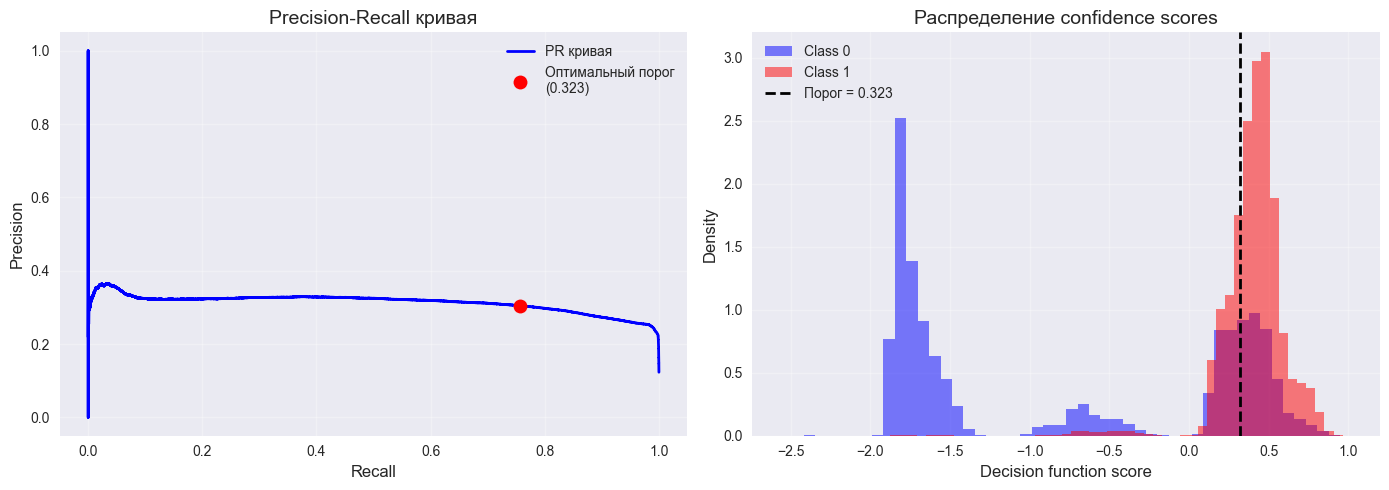

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Создаем график сравнения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Precision-Recall кривая с оптимальным порогом
y_scores = best_model.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Находим оптимальный порог (F1 максимизация)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

axes[0].plot(recall, precision, 'b-', linewidth=2, label='PR кривая')
axes[0].plot(recall[optimal_idx], precision[optimal_idx], 'ro', 
            markersize=10, label=f'Оптимальный порог\n({optimal_threshold:.3f})')
axes[0].set_xlabel('Recall', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision-Recall кривая', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Гистограмма распределения confidence scores
axes[1].hist(y_scores[y_test == 0], bins=50, alpha=0.5,
            label='Class 0', color='blue', density=True)
axes[1].hist(y_scores[y_test == 1], bins=50, alpha=0.5,
            label='Class 1', color='red', density=True)
axes[1].axvline(x=optimal_threshold, color='black', linestyle='--',
                linewidth=2, label=f'Порог = {optimal_threshold:.3f}')
axes[1].set_xlabel('Decision function score', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('Распределение confidence scores', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Применение гиперпараметра Optune

In [17]:
import os
import time
import joblib
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

OPTUNA_LINEARSVC_FILE = 'optuna_linearsvc_result.pkl'

# Создаем pipeline
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC(
        random_state=42,
        max_iter=5000
    ))
])

def optuna_objective(trial):
    """
    Целевая функция для Optuna - оптимизирует F1-score
    Общее количество фолдов не превышает 30
    """
    
    try:
        # Значения параметров для каждого испытания (trial)
        params = {
            'classifier__C': trial.suggest_float('C', 1e-3, 100, log=True),
            'classifier__class_weight': trial.suggest_categorical('class_weight', 
                                                                  ['balanced', {0: 1, 1: 5}, {0: 1, 1: 8}]),
            'classifier__loss': trial.suggest_categorical('loss', ['hinge', 'squared_hinge']),
            'classifier__dual': trial.suggest_categorical('dual', [True, False]),
            'classifier__tol': trial.suggest_float('tol', 1e-5, 1e-2, log=True)
        }
        
        # Проверка совместимости параметров
        if params['classifier__loss'] == 'hinge' and params['classifier__dual'] == False:
            # Эта комбинация не поддерживается, возвращаем плохой результат
            return 0.0
        
        # Копируем существующий pipeline чтобы не изменять оригинал
        temp_pipeline = clone(full_pipeline)
        
        # Обновляем параметры в пайплайне
        temp_pipeline.set_params(**params)
        
        # Используем подвыборку и ограничиваем количество фолдов
        # 15 итераций × 2 фолда = 30 фолдов всего
        n_splits = 2  # уменьшаем количество фолдов для ускорения
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        # Используем ПОДВЫБОРКУ для скорости (максимум 15K для еще большей скорости)
        sample_size = min(15000, len(X_train))
        if sample_size < len(X_train):
            indices = np.random.choice(len(X_train), sample_size, replace=False)
            X_sample = X_train.iloc[indices]
            y_sample = y_train.iloc[indices]
        else:
            X_sample = X_train
            y_sample = y_train
        
        print(f"  Обучение на {sample_size} samples, {n_splits} folds...", end="")
        
        # Быстрая кросс-валидация
        scores = cross_val_score(
            temp_pipeline, 
            X_sample, 
            y_sample, 
            cv=cv, 
            scoring='f1',
            n_jobs=1,  # используем 1 процесс для стабильности
            error_score='raise'  # поднимаем ошибки для отладки
        )
        
        average_f1 = scores.mean()
        print(f" F1: {average_f1:.4f}")
        
        return average_f1
        
    except Exception as e:
        print(f" Ошибка: {e}")
        # Возвращаем плохой результат при ошибке
        return 0.0

# Создаем исследование Optuna (максимизируем F1-score)
if os.path.exists(OPTUNA_LINEARSVC_FILE):
    print(" Загружаем сохраненное исследование Optuna...")
    optuna_study = joblib.load(OPTUNA_LINEARSVC_FILE)
    print(f" Загружено {len(optuna_study.trials)} итераций")
else:
    print(" Запуск Optuna (макс 15 итераций, 2 фолда)...")
    print(f"Используется: 2-fold CV, подвыборка 15K, всего фолдов ≤ 30")
    
    optuna_study = optuna.create_study(
        direction='maximize',  # максимизируем F1-score
        study_name='linear_svc_optuna',
        sampler=optuna.samplers.TPESampler(seed=42)  # Используем TPE (байесовский метод)
    )
    
    # Запускаем оптимизацию
    start_time = time.time()
    optuna_study.optimize(optuna_objective, n_trials=15, show_progress_bar=True)
    end_time = time.time()
    
    print(f" Optuna завершена за {(end_time - start_time)/60:.1f} минут")
    print(f"Всего фолдов использовано: 15 итераций × 2 фолда = 30 фолдов")
    joblib.dump(optuna_study, OPTUNA_LINEARSVC_FILE)

# Получение лучших параметров
best_params = optuna_study.best_params
print(f"\nЛучший F1-score: {optuna_study.best_value:.4f}")
print("Лучшие параметры:", best_params)

# Обучаем финальную модель на ВСЕХ данных с лучшими параметрами
print("\n Обучаем финальную модель на всех данных...")

# Создаем финальный pipeline с лучшими параметрами
# Проверяем совместимость параметров
if best_params.get('loss') == 'hinge' and best_params.get('dual') == False:
    # Автоматически исправляем несовместимую комбинацию
    print("Обнаружена несовместимая комбинация параметров, устанавливаем dual=True")
    best_params['dual'] = True

final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC(
        C=best_params['C'],
        class_weight=best_params['class_weight'],
        loss=best_params['loss'],
        dual=best_params['dual'],
        tol=best_params['tol'],
        random_state=42,
        max_iter=5000
    ))
])

# Обучаем финальную модель
final_pipeline.fit(X_train, y_train)

# Сохранение моделей
joblib.dump(final_pipeline, 'linear_svc_optuna_model.joblib')
joblib.dump(optuna_study, 'optuna_study_linearsvc.joblib')

print("======================= Сохранение моделей =======================")
print(f"\nМодели сохранены:")
print(f"- LinearSVC (Optuna): 'linear_svc_optuna_model.joblib'")
print(f"- Исследование Optuna: 'optuna_study_linearsvc.joblib'")

print("======================= Затраченное время =======================")
print(f"Время оптимизации: {(end_time - start_time):.2f} сек")
print(f"Всего фолдов использовано: 30")

[I 2025-12-17 21:26:21,984] A new study created in memory with name: linear_svc_optuna


 Запуск Optuna (макс 15 итераций, 2 фолда)...
Используется: 2-fold CV, подвыборка 15K, всего фолдов ≤ 30


Best trial: 2. Best value: 0.400507:  20%|██        | 3/15 [00:00<00:00, 17.98it/s]

[I 2025-12-17 21:26:21,986] Trial 0 finished with value: 0.0 and parameters: {'C': 0.0745934328572655, 'class_weight': 'balanced', 'loss': 'hinge', 'dual': False, 'tol': 0.0006358358856676254}. Best is trial 0 with value: 0.0.
[I 2025-12-17 21:26:21,989] Trial 1 finished with value: 0.0 and parameters: {'C': 3.4702669886504163, 'class_weight': {0: 1, 1: 5}, 'loss': 'hinge', 'dual': False, 'tol': 0.00037520558551242813}. Best is trial 0 with value: 0.0.
  Обучение на 15000 samples, 2 folds... F1: 0.4005
[I 2025-12-17 21:26:22,150] Trial 2 finished with value: 0.40050675449198136 and parameters: {'C': 0.14445251022763064, 'class_weight': {0: 1, 1: 5}, 'loss': 'squared_hinge', 'dual': False, 'tol': 3.972110727381908e-05}. Best is trial 2 with value: 0.40050675449198136.
[I 2025-12-17 21:26:22,154] Trial 3 finished with value: 0.0 and parameters: {'C': 0.37253938395788866, 'class_weight': {0: 1, 1: 8}, 'loss': 'hinge', 'dual': False, 'tol': 0.002661901888489057}. Best is trial 2 with value

Best trial: 4. Best value: 0.416383:  33%|███▎      | 5/15 [00:00<00:00, 15.54it/s]

 F1: 0.4164
[I 2025-12-17 21:26:22,297] Trial 4 finished with value: 0.4163833449451969 and parameters: {'C': 0.03334792728637585, 'class_weight': {0: 1, 1: 5}, 'loss': 'squared_hinge', 'dual': False, 'tol': 5.9750279999602906e-05}. Best is trial 4 with value: 0.4163833449451969.
  Обучение на 15000 samples, 2 folds... F1: 0.4054
[I 2025-12-17 21:26:22,445] Trial 5 finished with value: 0.4054228207595203 and parameters: {'C': 2.0540519425388455, 'class_weight': {0: 1, 1: 8}, 'loss': 'squared_hinge', 'dual': False, 'tol': 0.004835952776465951}. Best is trial 4 with value: 0.4163833449451969.
  Обучение на 15000 samples, 2 folds...

Best trial: 4. Best value: 0.416383:  53%|█████▎    | 8/15 [00:02<00:02,  2.70it/s]

 F1: 0.4003
[I 2025-12-17 21:26:24,192] Trial 6 finished with value: 0.4002756918062153 and parameters: {'C': 0.9761125443110458, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'dual': True, 'tol': 0.003063462210622081}. Best is trial 4 with value: 0.4163833449451969.
  Обучение на 15000 samples, 2 folds... F1: 0.3972
[I 2025-12-17 21:26:24,371] Trial 7 finished with value: 0.39722685082424636 and parameters: {'C': 0.06078083099681954, 'class_weight': {0: 1, 1: 5}, 'loss': 'hinge', 'dual': True, 'tol': 3.9459088110999965e-05}. Best is trial 4 with value: 0.4163833449451969.


Best trial: 4. Best value: 0.416383:  60%|██████    | 9/15 [00:02<00:01,  3.16it/s]

  Обучение на 15000 samples, 2 folds... F1: 0.3955
[I 2025-12-17 21:26:24,520] Trial 8 finished with value: 0.39548495392896477 and parameters: {'C': 0.0010656401760606447, 'class_weight': 'balanced', 'loss': 'hinge', 'dual': True, 'tol': 0.0038842777547031426}. Best is trial 4 with value: 0.4163833449451969.
  Обучение на 15000 samples, 2 folds...

Best trial: 4. Best value: 0.416383:  67%|██████▋   | 10/15 [00:02<00:01,  3.60it/s]

 F1: 0.4074
[I 2025-12-17 21:26:24,686] Trial 9 finished with value: 0.40744736647384755 and parameters: {'C': 1.3076473382928542, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'dual': False, 'tol': 0.00026100256506134784}. Best is trial 4 with value: 0.4163833449451969.
  Обучение на 15000 samples, 2 folds...

Best trial: 10. Best value: 0.432695:  73%|███████▎  | 11/15 [00:04<00:02,  1.47it/s]

 F1: 0.4327
[I 2025-12-17 21:26:26,447] Trial 10 finished with value: 0.43269534152812494 and parameters: {'C': 53.17196633982097, 'class_weight': {0: 1, 1: 5}, 'loss': 'squared_hinge', 'dual': True, 'tol': 1.1529697426955652e-05}. Best is trial 10 with value: 0.43269534152812494.
  Обучение на 15000 samples, 2 folds...

Best trial: 10. Best value: 0.432695:  80%|████████  | 12/15 [00:06<00:02,  1.04it/s]

 F1: 0.4275
[I 2025-12-17 21:26:28,131] Trial 11 finished with value: 0.4275136004258705 and parameters: {'C': 34.54013068456224, 'class_weight': {0: 1, 1: 5}, 'loss': 'squared_hinge', 'dual': True, 'tol': 1.026607325456727e-05}. Best is trial 10 with value: 0.43269534152812494.
  Обучение на 15000 samples, 2 folds...

Best trial: 10. Best value: 0.432695:  87%|████████▋ | 13/15 [00:08<00:02,  1.30s/it]

 F1: 0.3701
[I 2025-12-17 21:26:30,306] Trial 12 finished with value: 0.3701413844400128 and parameters: {'C': 91.5420442066172, 'class_weight': {0: 1, 1: 5}, 'loss': 'squared_hinge', 'dual': True, 'tol': 1.1202569850886766e-05}. Best is trial 10 with value: 0.43269534152812494.
  Обучение на 15000 samples, 2 folds...

Best trial: 10. Best value: 0.432695:  93%|█████████▎| 14/15 [00:10<00:01,  1.50s/it]

 F1: 0.4089
[I 2025-12-17 21:26:32,278] Trial 13 finished with value: 0.40894121551186186 and parameters: {'C': 65.0504791303574, 'class_weight': {0: 1, 1: 5}, 'loss': 'squared_hinge', 'dual': True, 'tol': 1.0243799212329336e-05}. Best is trial 10 with value: 0.43269534152812494.
  Обучение на 15000 samples, 2 folds...

Best trial: 10. Best value: 0.432695: 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]

 F1: 0.4087
[I 2025-12-17 21:26:34,128] Trial 14 finished with value: 0.4087236269771948 and parameters: {'C': 13.621945681080282, 'class_weight': {0: 1, 1: 5}, 'loss': 'squared_hinge', 'dual': True, 'tol': 0.00011038251665362917}. Best is trial 10 with value: 0.43269534152812494.
 Optuna завершена за 0.2 минут
Всего фолдов использовано: 15 итераций × 2 фолда = 30 фолдов

Лучший F1-score: 0.4327
Лучшие параметры: {'C': 53.17196633982097, 'class_weight': {0: 1, 1: 5}, 'loss': 'squared_hinge', 'dual': True, 'tol': 1.1529697426955652e-05}

 Обучаем финальную модель на всех данных...


======================= Сохранение моделей =======================

Модели сохранены:
- LinearSVC (Optuna): 'linear_svc_optuna_model.joblib'
- Исследование Optuna: 'optuna_study_linearsvc.joblib'
======================= Затраченное время =======================
Время оптимизации: 12.15 сек
Всего фолдов использовано: 30


Оценка метрик

In [18]:
# Делаем предсказания на тестовых данных
y_pred = final_pipeline.predict(X_test)

# Получаем confidence scores для метрик, требующих вероятностей/оценок
y_scores = final_pipeline.decision_function(X_test)

# Рассчитываем метрики
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='binary'
)
roc_auc = roc_auc_score(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

print("\nМетрики модели LinearSVC (Optuna оптимизация):")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print("\nКлассификационный отчет:")
print(classification_report(y_test, y_pred))

print(f"\nЛучшие параметры Optuna:")
print(f"C: {best_params['C']:.6f}")
print(f"class_weight: {best_params['class_weight']}")
print(f"loss: {best_params['loss']}")
print(f"dual: {best_params['dual']}")
print(f"tol: {best_params['tol']:.6f}")
print(f"Лучший CV F1-score: {optuna_study.best_value:.4f}")


Метрики модели LinearSVC (Optuna оптимизация):
Precision: 0.2951
Recall: 0.7462
F1-Score: 0.4229
ROC-AUC: 0.8319
Average Precision: 0.3091

Классификационный отчет:
              precision    recall  f1-score   support

           0       0.95      0.75      0.84    438397
           1       0.30      0.75      0.42     61603

    accuracy                           0.75    500000
   macro avg       0.62      0.75      0.63    500000
weighted avg       0.87      0.75      0.79    500000


Лучшие параметры Optuna:
C: 53.171966
class_weight: {0: 1, 1: 5}
loss: squared_hinge
dual: True
tol: 0.000012
Лучший CV F1-score: 0.4327


Визуализация результатов

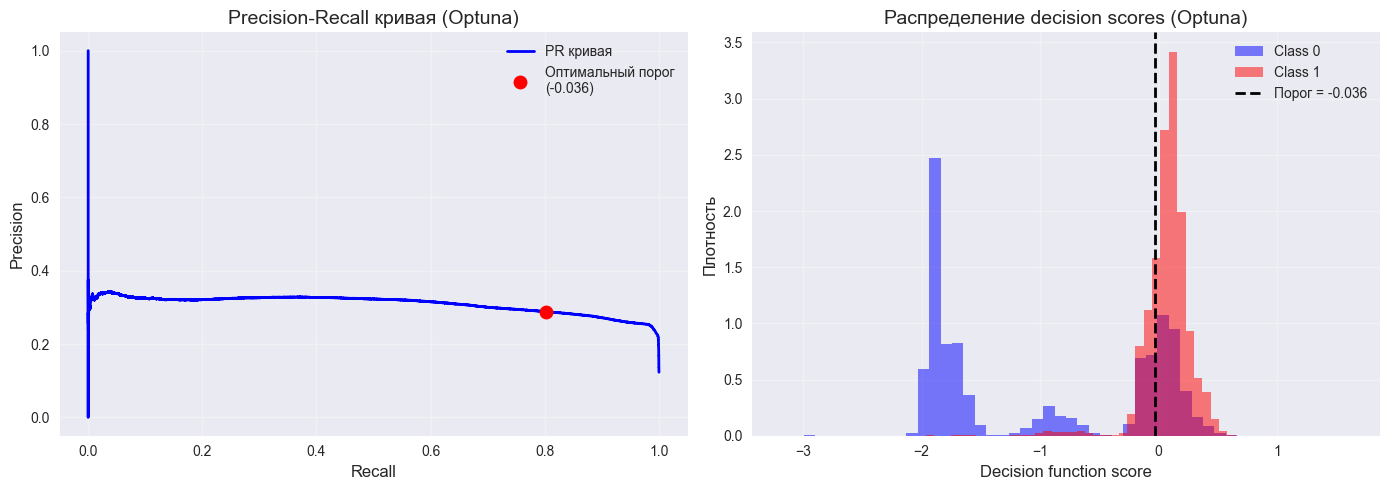

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Получаем decision function scores
y_scores = final_pipeline.decision_function(X_test)

# Рассчитываем Precision-Recall кривую
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_scores)

# Находим оптимальный порог (F1 максимизация)
f1_scores = 2 * (precision_vals[:-1] * recall_vals[:-1]) / (precision_vals[:-1] + recall_vals[:-1] + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Создаем график сравнения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Precision-Recall кривая с оптимальным порогом
axes[0].plot(recall_vals, precision_vals, 'b-', linewidth=2, label='PR кривая')
axes[0].plot(recall_vals[optimal_idx], precision_vals[optimal_idx], 'ro', 
            markersize=10, label=f'Оптимальный порог\n({optimal_threshold:.3f})')
axes[0].set_xlabel('Recall', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision-Recall кривая (Optuna)', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Сравнение распределения decision function scores
axes[1].hist(y_scores[y_test == 0], bins=50, alpha=0.5, 
            label='Class 0', color='blue', density=True)
axes[1].hist(y_scores[y_test == 1], bins=50, alpha=0.5, 
            label='Class 1', color='red', density=True)
axes[1].axvline(x=optimal_threshold, color='black', linestyle='--', 
                linewidth=2, label=f'Порог = {optimal_threshold:.3f}')
axes[1].set_xlabel('Decision function score', fontsize=12)
axes[1].set_ylabel('Плотность', fontsize=12)
axes[1].set_title('Распределение decision scores (Optuna)', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Подбор гиперпараметров методом HalvingGridSearchCV

In [6]:
import os
import time
import joblib
import numpy as np
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

HALVING_SEARCH_FILE = 'halving_linearsvc_result.pkl'

# Создаем pipeline
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC(
        random_state=42,
        max_iter=5000
    ))
])

# Определяем пространство параметров для HalvingGridSearchCV
param_grid = {
    'classifier__C': [0.01, 0.1, 1.0, 10.0, 50.0],
    'classifier__class_weight': ['balanced', {0: 1, 1: 3}, {0: 1, 1: 5}, {0: 1, 1: 8}],
    'classifier__loss': ['squared_hinge'],  # только совместимый вариант
    'classifier__dual': [True],  # только совместимый вариант
    'classifier__tol': [1e-4, 1e-3, 1e-2]
}

print(" Запуск HalvingGridSearchCV...")
print(f"Train данных: {X_train.shape[0]:,} образцов")
print(f"Test данных: {X_test.shape[0]:,} образцов")
print(f"Пространство параметров: {sum([len(v) for v in param_grid.values()])} комбинаций")

# Создаем HalvingGridSearchCV
start_time = time.time()

halving_search = HalvingGridSearchCV(
    estimator=full_pipeline,
    param_grid=param_grid,
    factor=2,  # увеличиваем выборку в 2 раза на каждом этапе
    min_resources=50000,  # начинаем с 50,000 образцов (5% от 1M)
    max_resources=200000,  # максимум 200,000 образцов на последнем этапе (20% от 1M)
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # 3 фолда
    scoring='f1',
    n_jobs=-1,  # используем все ядра
    verbose=1,  # показываем прогресс
    random_state=42,
    aggressive_elimination=False  # менее агрессивное отсечение
)

# Проверяем наличие сохраненного результата
if os.path.exists(HALVING_SEARCH_FILE):
    print(" Загружаем сохраненный результат HalvingGridSearchCV...")
    halving_search = joblib.load(HALVING_SEARCH_FILE)
    print(" Результат загружен")
else:
    print(" Запуск HalvingGridSearchCV на обучающих данных...")
    
    # Используем подвыборку для ускорения поиска (но больше, чем раньше)
    sample_size = min(200000, len(X_train))  # 200K вместо 20K
    if sample_size < len(X_train):
        indices = np.random.choice(len(X_train), sample_size, replace=False)
        X_sample = X_train.iloc[indices]
        y_sample = y_train.iloc[indices]
    else:
        X_sample = X_train
        y_sample = y_train
    
    print(f"Используем подвыборку: {sample_size:,} образцов ({sample_size/len(X_train)*100:.1f}% данных)")
    
    # Запускаем поиск
    halving_search.fit(X_sample, y_sample)
    end_time = time.time()
    
    print(f" HalvingGridSearchCV завершен за {(end_time - start_time)/60:.1f} минут")
    
    # Сохраняем результат
    joblib.dump(halving_search, HALVING_SEARCH_FILE)

# Анализируем результаты
print("\n Результаты HalvingGridSearchCV:")
print(f"Лучшие параметры: {halving_search.best_params_}")
print(f"Лучший F1-score: {halving_search.best_score_:.4f}")
print(f"Количество итераций: {halving_search.n_iterations_}")
print(f"Всего оценок: {halving_search.n_resources_}")

#  Обучаем финальную модель на ВСЕХ данных с лучшими параметрами
print("\n Обучаем финальную модель на ВСЕХ 1,000,000 данных...")

# Создаем финальный pipeline с лучшими параметрами
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC(
        C=halving_search.best_params_['classifier__C'],
        class_weight=halving_search.best_params_['classifier__class_weight'],
        loss=halving_search.best_params_['classifier__loss'],
        dual=halving_search.best_params_['classifier__dual'],
        tol=halving_search.best_params_['classifier__tol'],
        random_state=42,
        max_iter=5000
    ))
])

# Обучаем финальную модель на ВСЕХ данных
final_pipeline.fit(X_train, y_train)

# Сохранение моделей
joblib.dump(final_pipeline, 'linear_svc_halving_model.joblib')
joblib.dump(halving_search, 'halving_search_linearsvc.joblib')

print("======================= Сохранение моделей =======================")
print(f"\nМодели сохранены:")
print(f"- LinearSVC (HalvingGridSearchCV): 'linear_svc_halving_model.joblib'")
print(f"- Результат HalvingSearch: 'halving_search_linearsvc.joblib'")

print("======================= Затраченное время =======================")
print(f"Время оптимизации: {(time.time() - start_time):.2f} сек")

# Дополнительный анализ результатов
print("\n Анализ этапов HalvingGridSearchCV:")
for i in range(halving_search.n_iterations_):
    print(f"\nЭтап {i + 1}:")
    print(f"  Параметров оценивалось: {halving_search.n_candidates_[i]}")
    print(f"  Использовано образцов на кандидата: {halving_search.n_resources_[i]:,}")
    if i < halving_search.n_iterations_ - 1:
        print(f"  Перешло на следующий этап: {halving_search.n_candidates_[i+1]} параметров")

 Запуск HalvingGridSearchCV...
Train данных: 1,000,000 образцов
Test данных: 500,000 образцов
Пространство параметров: 14 комбинаций
 Загружаем сохраненный результат HalvingGridSearchCV...
 Результат загружен

 Результаты HalvingGridSearchCV:
Лучшие параметры: {'classifier__C': 1.0, 'classifier__class_weight': {0: 1, 1: 8}, 'classifier__dual': True, 'classifier__loss': 'squared_hinge', 'classifier__tol': 0.01}
Лучший F1-score: 0.4030
Количество итераций: 6
Всего оценок: [625, 1250, 2500, 5000, 10000, 20000]

 Обучаем финальную модель на ВСЕХ 1,000,000 данных...
======================= Сохранение моделей =======================

Модели сохранены:
- LinearSVC (HalvingGridSearchCV): 'linear_svc_halving_model.joblib'
- Результат HalvingSearch: 'halving_search_linearsvc.joblib'
======================= Затраченное время =======================
Время оптимизации: 800.34 сек

 Анализ этапов HalvingGridSearchCV:

Этап 1:
  Параметров оценивалось: 54
  Использовано образцов на кандидата: 625
  П

Визуализация результатов HalvingSearchCV

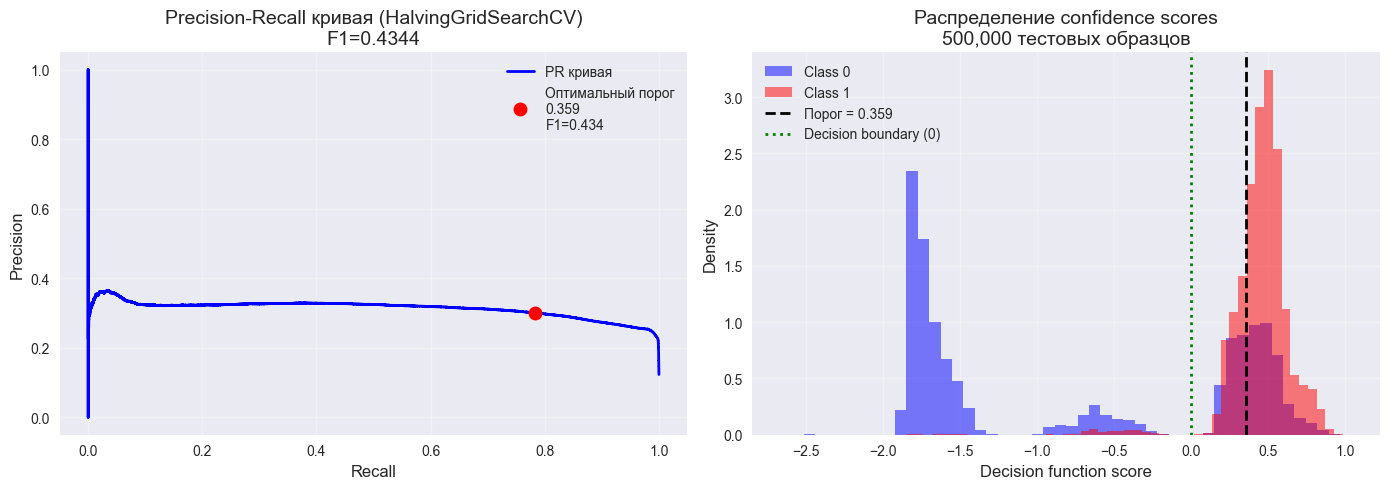


📊 Анализ оптимального порога:
Оптимальный порог decision function: 0.358784
F1-score при этом пороге: 0.4344
Precision: 0.3006
Recall: 0.7829

F1-score при пороге 0 (стандартный): 0.4030
Улучшение с оптимальным порогом: 0.0314
F1-score с оптимальным порогом 0.359: 0.4344


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np

# Создаем график сравнения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Precision-Recall кривая с оптимальным порогом
y_scores = final_pipeline.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Находим оптимальный порог (F1 максимизация)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Рассчитываем F1 в оптимальной точке
optimal_f1 = f1_scores[optimal_idx]

axes[0].plot(recall, precision, 'b-', linewidth=2, label='PR кривая')
axes[0].plot(recall[optimal_idx], precision[optimal_idx], 'ro', 
            markersize=10, label=f'Оптимальный порог\n{optimal_threshold:.3f}\nF1={optimal_f1:.3f}')
axes[0].set_xlabel('Recall', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title(f'Precision-Recall кривая (HalvingGridSearchCV)\nF1={optimal_f1:.4f}', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Гистограмма распределения confidence scores
axes[1].hist(y_scores[y_test == 0], bins=50, alpha=0.5,
            label='Class 0', color='blue', density=True)
axes[1].hist(y_scores[y_test == 1], bins=50, alpha=0.5,
            label='Class 1', color='red', density=True)
axes[1].axvline(x=optimal_threshold, color='black', linestyle='--',
                linewidth=2, label=f'Порог = {optimal_threshold:.3f}')
axes[1].axvline(x=0, color='green', linestyle=':', 
                linewidth=2, label='Decision boundary (0)')
axes[1].set_xlabel('Decision function score', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title(f'Распределение confidence scores\n500,000 тестовых образцов', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Дополнительная информация о пороге
print(f"\n Анализ оптимального порога:")
print(f"Оптимальный порог decision function: {optimal_threshold:.6f}")
print(f"F1-score при этом пороге: {optimal_f1:.4f}")
print(f"Precision: {precision[optimal_idx]:.4f}")
print(f"Recall: {recall[optimal_idx]:.4f}")

# Сравнение с порогом 0
y_pred_default = final_pipeline.predict(X_test)  # порог 0
from sklearn.metrics import f1_score as f1
f1_default = f1(y_test, y_pred_default)
print(f"\nF1-score при пороге 0 (стандартный): {f1_default:.4f}")
print(f"Улучшение с оптимальным порогом: {(optimal_f1 - f1_default):.4f}")

# Проверяем, можно ли применить оптимальный порог на практике
y_pred_optimal = (y_scores > optimal_threshold).astype(int)
f1_optimal = f1(y_test, y_pred_optimal)
print(f"F1-score с оптимальным порогом {optimal_threshold:.3f}: {f1_optimal:.4f}")

# Оценка моделей

In [ ]:
# Вывод лучших параметров из всех методов оптимизации
print("="*70)
print("ЛУЧШИЕ ПАРАМЕТРЫ ИЗ ВСЕХ МЕТОДОВ ОПТИМИЗАЦИИ")
print("="*70)

if 'optuna_study' in locals():
    print("\n Optuna (байесовская оптимизация):")
    print(f"   {optuna_study.best_trial.params}")

if 'grid_search' in locals():
    print("\n GridSearchCV (полный перебор):")
    print(f"   {grid_search.best_params_}")

if 'random_search' in locals():
    print("\n RandomSearchCV (случайный поиск):")
    print(f"   {random_search.best_params_}")

if 'hyperopt_data' in locals():
    print("\n Hyperopt (Tree-structured Parzen Estimator):")
    # Преобразуем параметры Hyperopt в читаемый формат
    hyperopt_best_params = hyperopt_data['best']
    readable_params = {
        'classifier__C': hyperopt_best_params['classifier__C'],
        'classifier__class_weight': ['balanced', {0: 1, 1: 5}, {0: 1, 1: 8}][int(hyperopt_best_params['classifier__class_weight'])],
        'classifier__loss': 'squared_hinge',
        'classifier__dual': True,
        'classifier__tol': 1e-3
    }
    print(f"   {readable_params}")

if 'halving_search' in locals():
    print("\n HalvingGridSearchCV (последовательное уменьшение):")
    print(f"   {halving_search.best_params_}")

print("\n" + "="*70)

# Сравнение F1-scores если доступны
print("\n СРАВНЕНИЕ F1-SCORES:")
print("-"*40)

if 'optuna_study' in locals():
    print(f"Optuna: {optuna_study.best_value:.4f}")

if 'grid_search' in locals():
    print(f"GridSearchCV: {grid_search.best_score_:.4f}")

if 'random_search' in locals():
    print(f"RandomSearchCV: {random_search.best_score_:.4f}")

if 'hyperopt_data' in locals():
    # Находим лучший F1 из trials Hyperopt
    hyperopt_best_loss = min(trial['result']['loss'] for trial in hyperopt_data['trials'].trials)
    hyperopt_best_f1 = -hyperopt_best_loss  # т.к. loss = -f1
    print(f"Hyperopt: {hyperopt_best_f1:.4f}")

if 'halving_search' in locals():
    print(f"HalvingGridSearchCV: {halving_search.best_score_:.4f}")

print("\n" + "="*70)

# Создаем таблицу для сравнения
methods = []
params_list = []
scores = []

if 'optuna_study' in locals():
    methods.append('Optuna')
    params_list.append(optuna_study.best_trial.params)
    scores.append(optuna_study.best_value)

if 'grid_search' in locals():
    methods.append('GridSearchCV')
    params_list.append(grid_search.best_params_)
    scores.append(grid_search.best_score_)

if 'random_search' in locals():
    methods.append('RandomSearchCV')
    params_list.append(random_search.best_params_)
    scores.append(random_search.best_score_)

if 'hyperopt_data' in locals():
    methods.append('Hyperopt')
    params_list.append(readable_params)
    scores.append(hyperopt_best_f1)

if 'halving_search' in locals():
    methods.append('HalvingGridSearchCV')
    params_list.append(halving_search.best_params_)
    scores.append(halving_search.best_score_)

# Находим лучший метод
if scores:
    best_idx = np.argmax(scores)
    print(f"\n ЛУЧШИЙ МЕТОД: {methods[best_idx]}")
    print(f"F1-score: {scores[best_idx]:.4f}")
    print(f"Параметры: {params_list[best_idx]}")
    print("="*70)

ЛУЧШИЕ ПАРАМЕТРЫ ИЗ ВСЕХ МЕТОДОВ ОПТИМИЗАЦИИ

🚀 HalvingGridSearchCV (последовательное уменьшение):
   {'classifier__C': 1.0, 'classifier__class_weight': {0: 1, 1: 8}, 'classifier__dual': True, 'classifier__loss': 'squared_hinge', 'classifier__tol': 0.01}


📈 СРАВНЕНИЕ F1-SCORES:
----------------------------------------
HalvingGridSearchCV: 0.4030


🏆 ЛУЧШИЙ МЕТОД: HalvingGridSearchCV
F1-score: 0.4030
Параметры: {'classifier__C': 1.0, 'classifier__class_weight': {0: 1, 1: 8}, 'classifier__dual': True, 'classifier__loss': 'squared_hinge', 'classifier__tol': 0.01}


In [ ]:
# Список методов и их объектов
methods = {}

# Добавляем только те методы, которые существуют
if 'grid_search' in locals():
    methods['GridSearchCV'] = grid_search
    
if 'random_search' in locals():
    methods['RandomizedSearchCV'] = random_search
    
if 'hyperopt_data' in locals():
    methods['Hyperopt'] = hyperopt_data
    
if 'optuna_study' in locals():
    methods['Optuna'] = optuna_study
    
if 'halving_search' in locals():
    methods['HalvingGridSearchCV'] = halving_search

print(f" Найдено методов: {len(methods)}")
for method_name in methods.keys():
    print(f"  • {method_name}")

def get_best_model(method_name, method_obj):
    """
    Получение лучшей модели для каждого метода оптимизации
    """
    try:
        if method_name == 'GridSearchCV':
            return method_obj.best_estimator_
            
        elif method_name == 'RandomizedSearchCV':
            return method_obj.best_estimator_
            
        elif method_name == 'Optuna':
            # Создаем pipeline с лучшими параметрами из Optuna
            best_params = method_obj.best_trial.params
            
            # Проверяем и исправляем несовместимые параметры
            if best_params.get('loss') == 'hinge' and best_params.get('dual') == False:
                best_params['dual'] = True
            
            # Создаем pipeline
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('scaler', StandardScaler()),
                ('classifier', LinearSVC(
                    C=best_params['C'],
                    class_weight=best_params['class_weight'],
                    loss=best_params['loss'],
                    dual=best_params['dual'],
                    tol=best_params['tol'],
                    random_state=42,
                    max_iter=5000
                ))
            ])
            pipeline.fit(X_train, y_train)
            return pipeline
            
        elif method_name == 'Hyperopt':
            # Создаем pipeline с лучшими параметрами из Hyperopt
            best_params = method_obj['best']
            
            # Преобразуем параметры Hyperopt в читаемый формат
            readable_params = {}
            readable_params['classifier__C'] = best_params['classifier__C']
            
            class_weight_options = ['balanced', {0: 1, 1: 5}, {0: 1, 1: 8}]
            readable_params['classifier__class_weight'] = class_weight_options[
                int(best_params['classifier__class_weight'])
            ]
            
            readable_params['classifier__loss'] = 'squared_hinge'
            readable_params['classifier__dual'] = True
            readable_params['classifier__tol'] = 1e-3
            
            # Создаем pipeline
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('scaler', StandardScaler()),
                ('classifier', LinearSVC(
                    C=readable_params['classifier__C'],
                    class_weight=readable_params['classifier__class_weight'],
                    loss=readable_params['classifier__loss'],
                    dual=readable_params['classifier__dual'],
                    tol=readable_params['classifier__tol'],
                    random_state=42,
                    max_iter=5000
                ))
            ])
            pipeline.fit(X_train, y_train)
            return pipeline
            
        elif method_name == 'HalvingGridSearchCV':
            return method_obj.best_estimator_
            
        else:
            raise ValueError(f"Unknown method: {method_name}")
            
    except Exception as e:
        print(f" Ошибка при создании модели {method_name}: {e}")
        return None

# Получаем все модели
all_models_data = {}
results = []

print("\n Создание моделей для каждого метода...")
for method_name, method_obj in methods.items():
    print(f"  Создаем модель: {method_name}...", end="")
    
    model = get_best_model(method_name, method_obj)
    if model is not None:
        all_models_data[method_name] = model
        print(f" Успешно!")
    else:
        print(f" Неуспешно!")

print(f"\n Успешно создано моделей: {len(all_models_data)}/{len(methods)}")

# Сравниваем метрики всех моделей
print("\n" + "="*70)
print("СРАВНЕНИЕ МЕТРИК ВСЕХ МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*70)

for method_name, model in all_models_data.items():
    # Делаем предсказания
    y_pred = model.predict(X_test)
    y_scores = model.decision_function(X_test)
    
    # Рассчитываем метрики
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='binary'
    )
    roc_auc = roc_auc_score(y_test, y_scores)
    average_precision = average_precision_score(y_test, y_scores)
    
    # Сохраняем результаты
    results.append({
        'method': method_name,
        'model': model,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'average_precision': average_precision
    })
    
    # Выводим метрики
    print(f"\n{method_name}:")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  Avg Precision: {average_precision:.4f}")

# Находим лучшую модель по F1-Score
if results:
    best_result = max(results, key=lambda x: x['f1'])
    print("\n" + "="*70)
    print(f" ЛУЧШАЯ МОДЕЛЬ: {best_result['method']}")
    print(f"F1-Score: {best_result['f1']:.4f}")
    print(f"Precision: {best_result['precision']:.4f}")
    print(f"Recall: {best_result['recall']:.4f}")
    print("="*70)

# Сохраняем все модели и результаты
all_results_package = {
    'models': all_models_data,
    'results': results,
    'best_model': best_result if results else None,
    'metadata': {
        'train_shape': X_train.shape,
        'test_shape': X_test.shape,
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
    }
}

joblib.dump(all_results_package, 'all_models_comparison.joblib')

print(f"\n Все модели и результаты сохранены в 'all_models_comparison.joblib'")

 Найдено методов: 1
  • HalvingGridSearchCV

 Создание моделей для каждого метода...
  Создаем модель: HalvingGridSearchCV... Успешно!

 Успешно создано моделей: 1/1

СРАВНЕНИЕ МЕТРИК ВСЕХ МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ

HalvingGridSearchCV:
  F1-Score: 0.4030
  Precision: 0.2536
  Recall: 0.9809
  ROC-AUC: 0.8349
  Avg Precision: 0.3144

🏆 ЛУЧШАЯ МОДЕЛЬ: HalvingGridSearchCV
F1-Score: 0.4030
Precision: 0.2536
Recall: 0.9809

 Все модели и результаты сохранены в 'all_models_comparison.joblib'


In [14]:
# Добавьте этот импорт в начало файла
from sklearn.metrics import accuracy_score

# Обновите функцию get_best_model, чтобы избежать рекурсивных вызовов
def get_best_model(method_name, method_obj):
    """
    Получение лучшей модели для каждого метода оптимизации
    """
    try:
        print(f"    Получение модели для {method_name}...")
        
        if method_name == 'GridSearchCV':
            print(f"    Используем best_estimator_...")
            return method_obj.best_estimator_
            
        elif method_name == 'RandomizedSearchCV':
            print(f"    Используем best_estimator_...")
            return method_obj.best_estimator_
            
        elif method_name == 'Optuna':
            print(f"    Создаем модель с параметрами Optuna...")
            best_params = method_obj.best_trial.params
            
            # Проверяем и исправляем несовместимые параметры
            if best_params.get('loss') == 'hinge' and best_params.get('dual') == False:
                best_params['dual'] = True
            
            # Создаем pipeline
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('scaler', StandardScaler()),
                ('classifier', LinearSVC(
                    C=best_params['C'],
                    class_weight=best_params['class_weight'],
                    loss=best_params['loss'],
                    dual=best_params['dual'],
                    tol=best_params['tol'],
                    random_state=42,
                    max_iter=5000
                ))
            ])
            pipeline.fit(X_train, y_train)
            return pipeline
            
        elif method_name == 'Hyperopt':
            print(f"    Создаем модель с параметрами Hyperopt...")
            # Создаем pipeline с лучшими параметрами из Hyperopt
            best_params = method_obj['best']
            
            # Преобразуем параметры Hyperopt в читаемый формат
            readable_params = {}
            readable_params['classifier__C'] = best_params['classifier__C']
            
            class_weight_options = ['balanced', {0: 1, 1: 5}, {0: 1, 1: 8}]
            readable_params['classifier__class_weight'] = class_weight_options[
                int(best_params['classifier__class_weight'])
            ]
            
            readable_params['classifier__loss'] = 'squared_hinge'
            readable_params['classifier__dual'] = True
            readable_params['classifier__tol'] = 1e-3
            
            # Создаем pipeline
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('scaler', StandardScaler()),
                ('classifier', LinearSVC(
                    C=readable_params['classifier__C'],
                    class_weight=readable_params['classifier__class_weight'],
                    loss=readable_params['classifier__loss'],
                    dual=readable_params['classifier__dual'],
                    tol=readable_params['classifier__tol'],
                    random_state=42,
                    max_iter=5000
                ))
            ])
            pipeline.fit(X_train, y_train)
            return pipeline
            
        elif method_name == 'HalvingGridSearchCV':
            print(f"    Используем best_estimator_...")
            return method_obj.best_estimator_
            
        else:
            raise ValueError(f"Неизвестный метод: {method_name}")
            
    except Exception as e:
        print(f"     Ошибка в get_best_model для {method_name}: {e}")
        import traceback
        traceback.print_exc()
        return None

# Теперь исправленный основной код оценки
print("\n" + "="*70)
print("ОЦЕНКА ВСЕХ МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*70)

results = []
all_models_data = {}

for method_name, method_obj in methods.items():
    print(f"\n Оценка {method_name}...")
    
    try:
        # Получаем лучшую модель
        model = get_best_model(method_name, method_obj)
        
        if model is None:
            print(f"   Не удалось создать модель для {method_name}")
            results.append({
                'Method': method_name,
                'Accuracy': 'MODEL_ERROR',
                'Precision': 'MODEL_ERROR',
                'Recall': 'MODEL_ERROR',
                'F1': 'MODEL_ERROR',
                'ROC-AUC': 'MODEL_ERROR',
                'Avg Precision': 'MODEL_ERROR',
                'Optimal F1': 'MODEL_ERROR',
                'Optimal Threshold': 'MODEL_ERROR',
                'Training Time': 'MODEL_ERROR'
            })
            continue
            
        # Делаем предсказания на тестовой выборке
        print(f"  Делаем предсказания...")
        y_pred = model.predict(X_test)
        
        # Для LinearSVC используем decision_function вместо predict_proba
        print(f"  Получаем decision function scores...")
        y_scores = model.decision_function(X_test)
        
        # Вычисляем метрики
        print(f"  Вычисляем метрики...")
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average='binary'
        )
        
        # ROC-AUC и Average Precision используют decision function scores
        roc_auc = roc_auc_score(y_test, y_scores)
        average_precision = average_precision_score(y_test, y_scores)
        
        # Также вычисляем accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Вычисляем оптимальный порог по decision function
        print(f"  Ищем оптимальный порог...")
        precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_scores)
        f1_scores = 2 * (precision_vals[:-1] * recall_vals[:-1]) / (precision_vals[:-1] + recall_vals[:-1] + 1e-8)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        optimal_f1 = f1_scores[optimal_idx]
        
        # Сохраняем модель и предсказания для визуализации
        all_models_data[method_name] = {
            'model': model,
            'y_pred': y_pred,
            'y_scores': y_scores,
            'optimal_threshold': optimal_threshold,
            'optimal_f1': optimal_f1
        }
        
        # Сохраняем результаты
        results.append({
            'Method': method_name,
            'Accuracy': round(accuracy, 4),
            'Precision': round(precision, 4),
            'Recall': round(recall, 4),
            'F1': round(f1, 4),
            'ROC-AUC': round(roc_auc, 4),
            'Avg Precision': round(average_precision, 4),
            'Optimal F1': round(optimal_f1, 4),
            'Optimal Threshold': round(optimal_threshold, 6)
        })
        
        print(f"   Успешно оценено")
        print(f"     F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}, Accuracy: {accuracy:.4f}")
        
    except Exception as e:
        print(f"   Ошибка при оценке {method_name}: {e}")
        import traceback
        traceback.print_exc()
        results.append({
            'Method': method_name,
            'Accuracy': 'ERROR',
            'Precision': 'ERROR',
            'Recall': 'ERROR',
            'F1': 'ERROR',
            'ROC-AUC': 'ERROR',
            'Avg Precision': 'ERROR',
            'Optimal F1': 'ERROR',
            'Optimal Threshold': 'ERROR'
        })

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results)

print("\n" + "="*70)
print("РЕЗУЛЬТАТЫ ВСЕХ МОДЕЛЕЙ")
print("="*70)

# Сортируем по F1-Score (игнорируем ошибки)
valid_results = results_df[~results_df['F1'].isin(['ERROR', 'MODEL_ERROR'])].copy()
if not valid_results.empty:
    valid_results['F1'] = pd.to_numeric(valid_results['F1'])
    valid_results['Accuracy'] = pd.to_numeric(valid_results['Accuracy'])
    valid_results['ROC-AUC'] = pd.to_numeric(valid_results['ROC-AUC'])
    valid_results = valid_results.sort_values('F1', ascending=False)
    
    # Выводим красиво отформатированную таблицу
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.float_format', lambda x: f'{x:.4f}' if isinstance(x, (int, float)) else x)
    
    print("\n СРАВНИТЕЛЬНАЯ ТАБЛИЦА МЕТРИК:")
    print(valid_results.to_string(index=False))
    
    # Выводим лучшую модель
    best_row = valid_results.iloc[0]
    print(f"\n ЛУЧШАЯ МОДЕЛЬ: {best_row['Method']}")
    print(f"   F1-Score: {best_row['F1']:.4f}")
    print(f"   Accuracy: {best_row['Accuracy']:.4f}")
    print(f"   ROC-AUC: {best_row['ROC-AUC']:.4f}")
    
    # Сохраняем DataFrame в файл
    results_df.to_csv('all_models_comparison.csv', index=False)
    print(f"\n Результаты сохранены в 'all_models_comparison.csv'")
else:
    print(" Нет валидных результатов для сравнения")
    
# Выводим ошибки если есть
error_results = results_df[results_df['F1'].isin(['ERROR', 'MODEL_ERROR'])]
if not error_results.empty:
    print("\n МОДЕЛИ С ОШИБКАМИ:")
    for _, row in error_results.iterrows():
        print(f"  • {row['Method']}: {row['F1']}")

# Далее продолжается код визуализации и сохранения...


ОЦЕНКА ВСЕХ МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ

 Оценка HalvingGridSearchCV...
    Получение модели для HalvingGridSearchCV...
    Используем best_estimator_...
  Делаем предсказания...
  Получаем decision function scores...
  Вычисляем метрики...
  Ищем оптимальный порог...
   Успешно оценено
     F1: 0.4030, ROC-AUC: 0.8349, Accuracy: 0.6419

РЕЗУЛЬТАТЫ ВСЕХ МОДЕЛЕЙ

 СРАВНИТЕЛЬНАЯ ТАБЛИЦА МЕТРИК:
             Method  Accuracy  Precision  Recall     F1  ROC-AUC  Avg Precision  Optimal F1  Optimal Threshold
HalvingGridSearchCV    0.6419     0.2536  0.9809 0.4030   0.8349         0.3144      0.4321             0.3865

 ЛУЧШАЯ МОДЕЛЬ: HalvingGridSearchCV
   F1-Score: 0.4030
   Accuracy: 0.6419
   ROC-AUC: 0.8349

 Результаты сохранены в 'all_models_comparison.csv'



СРАВНЕНИЕ МЕТОДОВ ПОДБОРА ГИПЕРПАРАМЕТРОВ
             Method  Accuracy  Precision  Recall     F1  ROC-AUC  Avg Precision  Optimal F1  Optimal Threshold
HalvingGridSearchCV    0.6419     0.2536  0.9809 0.4030   0.8349         0.3144      0.4321             0.3865

 ЛУЧШИЙ МЕТОД: HalvingGridSearchCV
  F1-Score: 0.403
  Precision: 0.2536
  Recall: 0.9809
  ROC-AUC: 0.8349
  Accuracy: 0.6419


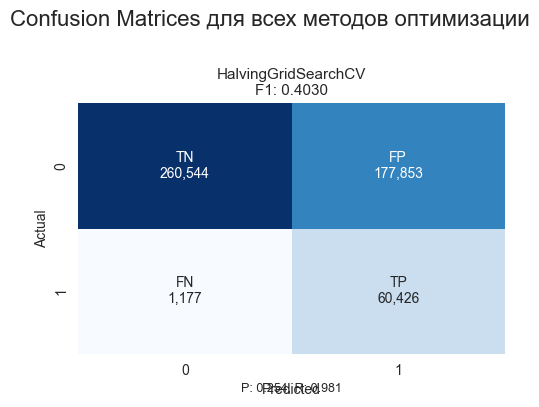


 Confusion matrices сохранены как 'confusion_matrices_all_methods.png'

ИТОГОВЫЙ ОТЧЕТ ПО ОПТИМИЗАЦИИ ГИПЕРПАРАМЕТРОВ

 Общее количество методов: 1
 Успешно оценено: 1
 С ошибками: 0

 Лучший метод: HalvingGridSearchCV
   F1-Score: 0.4030
   Accuracy: 0.6419
   ROC-AUC: 0.8349

 Статистика по F1-scores:
   Среднее: 0.4030
   Медиана: 0.4030
   Стандартное отклонение: nan
   Диапазон: 0.4030 - 0.4030

 Финальные результаты сохранены в 'final_comparison_results.csv'


<Figure size 800x550 with 0 Axes>

In [15]:
# Сначала убедимся, что все необходимые импорты есть
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Сортируем по F1-score (по убыванию)
# Создаем временную колонку для сортировки, заменяя 'ERROR' на -1
def sort_key(col):
    if col.name == 'F1':
        # Создаем числовую версию для сортировки
        numeric_values = []
        for val in col:
            if isinstance(val, str) and val in ['ERROR', 'MODEL_ERROR']:
                numeric_values.append(-1)
            elif isinstance(val, (int, float)):
                numeric_values.append(val)
            else:
                numeric_values.append(-1)
        return numeric_values
    return col

results_df_sorted = results_df.copy()
results_df_sorted['Sort_F1'] = pd.to_numeric(
    results_df_sorted['F1'].replace(['ERROR', 'MODEL_ERROR'], -1), 
    errors='coerce'
).fillna(-1)

results_df_sorted = results_df_sorted.sort_values('Sort_F1', ascending=False)
results_df_sorted = results_df_sorted.drop('Sort_F1', axis=1)

# Выводим таблицу
print("\n" + "="*80)
print("СРАВНЕНИЕ МЕТОДОВ ПОДБОРА ГИПЕРПАРАМЕТРОВ")
print("="*80)
print(results_df_sorted.to_string(index=False))

# Выводим лучший метод (исключая ошибки)
valid_results = results_df_sorted[~results_df_sorted['F1'].isin(['ERROR', 'MODEL_ERROR'])]
if not valid_results.empty:
    best_method_row = valid_results.iloc[0]
    print(f"\n ЛУЧШИЙ МЕТОД: {best_method_row['Method']}")
    print(f"  F1-Score: {best_method_row['F1']}")
    print(f"  Precision: {best_method_row['Precision']}")
    print(f"  Recall: {best_method_row['Recall']}")
    print(f"  ROC-AUC: {best_method_row['ROC-AUC']}")
    print(f"  Accuracy: {best_method_row['Accuracy']}")
else:
    print("\n Нет валидных методов для определения лучшего")

# Создаем confusion matrices для всех методов
valid_methods = [m for m in all_models_data.keys() 
                 if m in valid_results['Method'].values if not valid_results.empty]

if valid_methods:
    # Рассчитываем количество строк и столбцов для subplots
    n_methods = len(valid_methods)
    n_cols = min(3, n_methods)
    n_rows = (n_methods + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    
    # Если axes не массив, делаем его массивом для единообразия
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle('Confusion Matrices для всех методов оптимизации', fontsize=16, y=1.02)
    
    for idx, method_name in enumerate(valid_methods):
        row = idx // n_cols
        col = idx % n_cols
        
        model_data = all_models_data[method_name]
        
        # Получаем предсказания
        y_pred = model_data['y_pred']
        cm = confusion_matrix(y_test, y_pred)
        
        # Аннотации TN, FP, FN, TP
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            annot = np.array([[f'TN\n{tn:,}', f'FP\n{fp:,}'],
                              [f'FN\n{fn:,}', f'TP\n{tp:,}']])
        else:
            annot = cm.astype(str)
        
        # Находим соответствующий F1-score из results_df
        method_f1 = valid_results[valid_results['Method'] == method_name]['F1'].values[0]
        
        # Heatmap
        sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', 
                   ax=axes[row, col], cbar=False)
        axes[row, col].set_title(f'{method_name}\nF1: {method_f1:.4f}', fontsize=11)
        axes[row, col].set_xlabel('Predicted', fontsize=10)
        axes[row, col].set_ylabel('Actual', fontsize=10)
        
        # Добавляем дополнительные метрики в подзаголовок
        precision = valid_results[valid_results['Method'] == method_name]['Precision'].values[0]
        recall = valid_results[valid_results['Method'] == method_name]['Recall'].values[0]
        axes[row, col].text(0.5, -0.15, f'P: {precision:.3f}, R: {recall:.3f}', 
                           ha='center', transform=axes[row, col].transAxes, fontsize=9)
    
    # Скрываем пустые subplots
    for idx in range(len(valid_methods), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Сохраняем confusion matrices
    plt.savefig('confusion_matrices_all_methods.png', dpi=300, bbox_inches='tight')
    print(f"\n Confusion matrices сохранены как 'confusion_matrices_all_methods.png'")
else:
    print("\n Нет валидных методов для построения confusion matrices")

# Дополнительно: ROC-кривые для сравнения
if valid_methods and len(valid_methods) > 1:
    print("\n СРАВНЕНИЕ ROC-КРИВЫХ:")
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    colors = plt.cm.Set2(np.linspace(0, 1, len(valid_methods)))
    
    for idx, method_name in enumerate(valid_methods):
        model_data = all_models_data[method_name]
        y_scores = model_data['y_scores']
        
        # Вычисляем ROC-кривую
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = valid_results[valid_results['Method'] == method_name]['ROC-AUC'].values[0]
        
        ax.plot(fpr, tpr, lw=2, color=colors[idx], 
                label=f'{method_name} (AUC = {roc_auc:.3f})')
    
    # Диагональ для случайного классификатора
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.500)')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title('ROC-кривые для всех методов', fontsize=14)
    ax.legend(loc="lower right", fontsize=10)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Сохраняем ROC-кривые
    plt.savefig('roc_curves_all_methods.png', dpi=300, bbox_inches='tight')
    print(f" ROC-кривые сохранены как 'roc_curves_all_methods.png'")

# Создаем итоговый отчет
print("\n" + "="*80)
print("ИТОГОВЫЙ ОТЧЕТ ПО ОПТИМИЗАЦИИ ГИПЕРПАРАМЕТРОВ")
print("="*80)

print(f"\n Общее количество методов: {len(methods)}")
print(f" Успешно оценено: {len(valid_methods)}")
print(f" С ошибками: {len(methods) - len(valid_methods)}")

if not valid_results.empty:
    print(f"\n Лучший метод: {best_method_row['Method']}")
    print(f"   F1-Score: {best_method_row['F1']:.4f}")
    print(f"   Accuracy: {best_method_row['Accuracy']:.4f}")
    print(f"   ROC-AUC: {best_method_row['ROC-AUC']:.4f}")
    
    # Статистика по F1-scores
    f1_scores = valid_results['F1'].astype(float)
    print(f"\n Статистика по F1-scores:")
    print(f"   Среднее: {f1_scores.mean():.4f}")
    print(f"   Медиана: {f1_scores.median():.4f}")
    print(f"   Стандартное отклонение: {f1_scores.std():.4f}")
    print(f"   Диапазон: {f1_scores.min():.4f} - {f1_scores.max():.4f}")
    
    # Разница между лучшим и вторым лучшим
    if len(valid_results) > 1:
        second_best = valid_results.iloc[1]['F1']
        diff = float(best_method_row['F1']) - float(second_best)
        print(f"   Преимущество лучшего метода: +{diff:.4f}")

# Сохраняем финальный DataFrame
results_df_sorted.to_csv('final_comparison_results.csv', index=False)
print(f"\n Финальные результаты сохранены в 'final_comparison_results.csv'")